In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

from scipy.linalg import sqrtm

import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.censored_multivariate_normal import CensoredMultivariateNormal
from delphi.distributions.truncated_multivariate_normal import TruncatedMultivariateNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata, cov
from delphi.utils.helpers import Parameters
from cox.store import Store
from cox.readers import CollectionReader

In [12]:
args = Parameters({ 
    'samples': 5000, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/censored_multi/',
    'exp': '100D', 
    'trials': 1,
    'var': 10,
    'table_name': 'results',
    'd': 10,
})

Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

In [29]:
M = MultivariateNormal(ch.zeros(args.d), ch.eye(args.d))
samples = M.sample([args.samples])

if samples.size(1) == 2:
    plt.scatter(samples[:,0], samples[:,1])
    plt.show()

Truncate the Dataset

In [30]:
W = Uniform(-.5, .5)
centroid = W.sample([args.d,])
phi = oracle.Sphere(M.covariance_matrix, centroid, 3.0)
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

if S.size(1) == 2:
    plt.scatter(samples[:,0], samples[:,1])
    plt.scatter(S[:,0], S[:,1])
    plt.show()

alpha: 0.4182


In [31]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_cov = cov(S)
emp_scale = ch.from_numpy(sqrtm(emp_cov))
print("empirical scale: ", emp_scale)

emp = MultivariateNormal(emp_loc, emp_cov)
# normalize features
S_norm = (S - emp_loc) @ emp_scale.inverse()

samples_norm = (samples - emp_loc) @ emp_scale.inverse()

empirical mean:  tensor([ 0.1133,  0.1937,  0.0449,  0.1329,  0.1284,  0.1358,  0.0637, -0.0292,
         0.0845,  0.0297])
empirical scale:  tensor([[ 7.9520e-01,  7.3896e-03,  7.7632e-03,  1.0288e-04,  2.2045e-03,
          4.8098e-03,  7.6343e-03, -3.1825e-03, -5.5052e-03,  2.8713e-03],
        [ 7.3896e-03,  7.8142e-01,  2.0392e-03, -3.4765e-03, -1.9554e-03,
         -1.1475e-02,  9.3367e-03,  2.2140e-03, -5.6195e-04, -4.7048e-03],
        [ 7.7631e-03,  2.0392e-03,  7.9485e-01, -1.3062e-02, -1.1218e-02,
          8.3628e-03,  3.0274e-03, -2.0163e-03, -9.2033e-05,  7.6122e-03],
        [ 1.0291e-04, -3.4765e-03, -1.3062e-02,  7.8654e-01,  6.5361e-03,
          1.2060e-02, -1.6059e-02, -3.8652e-03, -9.6226e-03, -1.4372e-02],
        [ 2.2045e-03, -1.9554e-03, -1.1218e-02,  6.5360e-03,  7.9796e-01,
         -1.5577e-02, -6.3446e-03, -1.7947e-02, -3.0797e-03,  7.0788e-04],
        [ 4.8098e-03, -1.1475e-02,  8.3628e-03,  1.2060e-02, -1.5576e-02,
          7.8924e-01,  1.0471e-02, -5.9

In [19]:
if S_norm.size(1) == 2:
    plt.scatter(S_norm[:,0], S_norm[:,1])
    plt.show()

In [32]:
class UnNorm_Right_Distribution(oracle.oracle): 
    def __init__(self, right, loc, cov): 
        self.right = right 
        self.loc = loc 
        self.cov = cov
        self.scale = ch.from_numpy(sqrtm(self.cov))
        
    def __call__(self, x): 
        x_rescale = x @ self.scale + self.loc
        return (x_rescale < self.right).prod(dim=-1)
    
from torch.distributions.multivariate_normal import _batch_mahalanobis
class UnNorm_Sphere(oracle.oracle):
    """
    Spherical truncation
    """
    def __init__(self, covariance_matrix, centroid, radius, loc, cov):
        self._unbroadcasted_scale_tril = covariance_matrix.cholesky()
        self.centroid = centroid
        self.radius = radius
        self.loc, self.cov = loc, cov
        self.scale = ch.from_numpy(sqrtm(self.cov))

    def __call__(self, x):
        x_rescale = x @ self.scale + self.loc
        diff = x_rescale - self.centroid
        dist = ch.sqrt(_batch_mahalanobis(self._unbroadcasted_scale_tril, diff))
        return (dist < self.radius).float().flatten()

    def __str__(self): 
        return 'sphere'

In [33]:
# phi_norm = UnNorm_Right_Distribution(phi.right, emp_loc, emp_cov)
phi_norm = UnNorm_Sphere(M.covariance_matrix, phi.centroid, phi.radius, emp_loc, emp_cov)

Run algorithm to Remove Bias from the Dataset

In [9]:
store = Store(args.out_dir + 'censor_store')

Logging in: /Users/patroklos/Desktop/exp/censored_multi/censor_store/7806f75c-e9a0-48db-9f5a-99eed1805b46


In [36]:
train_kwargs = Parameters({'phi': phi_norm,
                          'alpha': alpha,
                          'epochs': 10, 
                          'batch_size': 100, 
                          'num_samples': 100,
                          'step_lr': 500,
                          'workers': 8,
                          'lr': 1e-1})
censored = CensoredMultivariateNormal(train_kwargs)
#                           'covariance_matrix': cov(samples_norm)}, 
#                             store=store)
censored.fit(S_norm)
rescale_loc = censored.loc_ @ emp_scale + emp_loc
rescale_var = censored.covariance_matrix_ @ emp_cov
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated covariance_matrix: ", rescale_var)

estimated mean:  tensor([-0.0462, -0.0030,  0.0733, -0.0300,  0.0676, -0.0125, -0.0564, -0.0403,
         0.0671,  0.0709])
estimated covariance_matrix:  tensor([[ 1.0546e+00,  4.2413e-02,  4.2549e-02,  6.8339e-02,  1.3823e-02,
          6.6569e-02,  6.3494e-02, -8.6178e-02, -4.2861e-02,  4.5829e-02],
        [ 4.5656e-02,  1.0837e+00, -8.8558e-02,  7.9301e-02, -1.5311e-02,
         -9.5394e-02,  1.1284e-01, -2.6808e-02, -7.2006e-03, -4.0744e-02],
        [ 4.0069e-02, -8.4347e-02,  1.0302e+00, -5.0404e-02, -1.0575e-01,
          8.5636e-02, -1.2117e-02,  7.5584e-04, -2.3713e-03,  3.1206e-02],
        [ 7.4343e-02,  8.1307e-02, -4.7162e-02,  9.8613e-01, -4.7622e-02,
          9.6239e-02, -1.8150e-02, -6.7325e-03, -1.0554e-01, -5.7892e-02],
        [ 1.1178e-02, -2.2228e-02, -9.9257e-02, -4.1751e-02,  1.0236e+00,
         -7.6605e-03, -4.8018e-03, -1.0464e-01,  2.4967e-02,  2.4802e-02],
        [ 6.6025e-02, -9.7194e-02,  8.2187e-02,  9.2922e-02, -6.7673e-03,
          1.0795e+00,  7.60

In [37]:
print("censored kl divergence: ", kl_divergence(m, M))
print("empirical kl divergence: ", kl_divergence(emp, M))

censored kl divergence:  tensor(0.1062)
empirical kl divergence:  tensor(0.5688)


In [19]:
store.close()

In [9]:
reader = CollectionReader(args.out_dir + 'censor_store')
logs = reader.df('logs')
reader.close()

  0%|          | 0/45 [00:00<?, ?it/s]


OSError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1400, in H5F__open
    unable to open file
  File "H5Fint.c", line 1700, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 623, in H5F__super_read
    truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048

End of HDF5 error back trace

Unable to open/create file '/Users/patroklos/Desktop/exp/censored_multi/censor_store/24c496e1-3260-4478-b471-4254cb1a92fb/store.h5'

In [21]:
sns.lineplot(data=logs, x='epoch', y='train_loss', label='Train', color='red')
ax = sns.lineplot(data=logs, x='epoch', y='val_loss', label='Val', color='blue')
ax.set_xlabel('Epoch')
ax.set_ylabel('Truncated Negative Log Likelihood')

NameError: name 'logs' is not defined

In [10]:
store = Store(args.out_dir + 'known_cov_again_')

Logging in: /Users/patroklos/Desktop/exp/censored_multi/known_cov_again_/38f284bf-52d9-40dd-b681-a74b81444f41


In [11]:
args = Parameters({'alpha': alpha,
                          'epochs': 20, 
                          'batch_size': 100, 
                          'step_lr': 500,
                          'lr': 1e-1,
                          'covariance_matrix': cov(samples_norm)})
truncated = TruncatedMultivariateNormal(args)
#                           store=store)
truncated.fit(S_norm)
rescale_loc = truncated.loc @ emp_scale + emp_loc
rescale_var = truncated.covariance_matrix @ emp_cov
# rescale_loc = truncated.loc 
# rescale_var = truncated.covariance_matrix 
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated covariance_matrix: ", rescale_var)

/Users/patroklos/Desktop/delphi_/delphi/distributions/censored_multivariate_normal.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  if (LA.eig(self.model.covariance_matrix).eigenvalues.float() < 0).any():


estimated mean:  tensor([-0.0216,  0.0051, -0.0640, -0.0120, -0.0334,  0.0528, -0.0978,  0.0360,
        -0.0051,  0.0202,  0.0634, -0.0085,  0.0513, -0.0017, -0.0269, -0.0664,
         0.0087, -0.0605, -0.0310, -0.0806, -0.0857,  0.0617,  0.0134, -0.0435,
         0.0801, -0.0162,  0.0548,  0.0671,  0.0333, -0.1126, -0.0463, -0.0636,
        -0.0113,  0.0903,  0.0023,  0.0718, -0.0638,  0.1071, -0.0230, -0.0359,
        -0.0325, -0.0166,  0.0095, -0.0518,  0.0750, -0.0116, -0.0495,  0.0595,
        -0.0189, -0.0052])
estimated covariance_matrix:  tensor([[ 1.0054e+01,  4.6578e-02, -1.9326e-02,  ...,  1.6204e-02,
          1.1520e-02, -1.9924e-02],
        [ 4.7354e-02,  1.0079e+01,  1.7322e-02,  ..., -6.7870e-02,
          1.2991e-02,  5.3739e-02],
        [-2.0277e-02,  1.5541e-02,  1.0045e+01,  ..., -7.9417e-03,
         -6.5581e-03,  1.4430e-02],
        ...,
        [ 1.5838e-02, -6.7965e-02, -7.4711e-03,  ...,  9.9841e+00,
          4.7903e-02,  2.2931e-02],
        [ 1.1855e-02,

In [12]:
print("truncated kl divergence: ", kl_divergence(m, M))
print("empirical kl divergence: ", kl_divergence(emp, M))

truncated kl divergence:  tensor(0.0130)
empirical kl divergence:  tensor(0.4088)


In [80]:
store.close()

In [81]:
reader = CollectionReader(args.out_dir + 'known_cov_again')
logs = reader.df('logs')
reader.close()

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

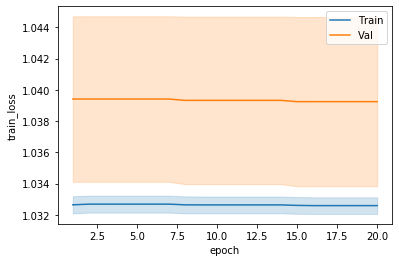

In [103]:
sns.lineplot(data=logs, x='epoch', y='train_loss', label='Train')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='Val')

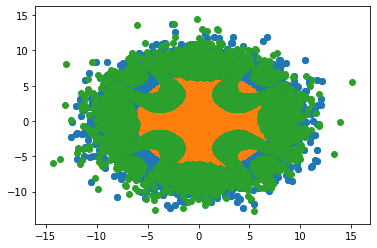

In [104]:
filter_ = truncated.phi_(samples)[...,None]
filter__ = phi(samples)[...,None]
S = samples[(filter_ * samples).nonzero(as_tuple=True)[0]]
S_ = samples[((filter_ * samples) == 0).prod(1, keepdim=True).nonzero(as_tuple=True)[0]]
S_phi = samples[(filter__ * samples).nonzero(as_tuple=True)[0]]

plt.scatter(S[:,0], S[:,1])
plt.scatter(S_phi[:,0], S_phi[:,1])

plt.scatter(S_[:,0], S_[:,1])

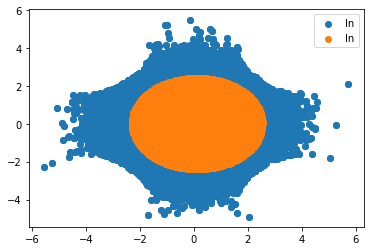

In [105]:
filter_ = truncated.phi_(S_norm)[...,None]
filter__ = truncated.phi_(samples_norm)[...,None]
S = S_norm[(filter_ * S_norm).nonzero(as_tuple=True)[0]]
S_ = samples_norm[(filter__ * samples_norm).nonzero(as_tuple=True)[0]]
# S_phi = samples[(filter__ * samples).nonzero(as_tuple=True)[0]]
plt.scatter(S_[:,0], S_[:,1], label='In')
plt.scatter(S[:,0], S[:,1], label='In')
# plt.scatter(S_phi[:,0], S_phi[:,1])


# plt.scatter(S_norm[:,0], S_norm[:,1], label='S')
plt.legend()

In [54]:
filter_.size(), filter__.size(), S_norm.size(), 

(torch.Size([3971, 1]), torch.Size([10000, 1]), torch.Size([8669, 2]))

In [55]:
censored = CensoredMultivariateNormal({
                          'phi': truncated.phi_,
                          'alpha': alpha,
                          'epochs': 20, 
                          'batch_size': 100, 
                          'num_samples': 100,
                          'step_lr': 500,
                          'lr': 1e-1})
censored.fit(S_norm)
rescale_loc = censored.loc @ emp_scale + emp_loc
rescale_var = censored.covariance_matrix @ emp_cov
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated covariance_matrix: ", rescale_var)

cov norm:  tensor(1.4189, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4341, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4435, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4401, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4460, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4583, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4536, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4616, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4458, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4376, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4501, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4538, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4611, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4545, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4633, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4658, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4619, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4725, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4641, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4458, grad_

cov norm:  tensor(1.4043, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4021, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4070, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4029, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4027, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4029, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4007, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4076, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4114, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4106, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4157, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4074, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4059, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4120, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4088, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4186, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4204, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4339, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4199, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4150, grad_

cov norm:  tensor(1.4128, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4039, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4134, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4210, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4181, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4183, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4257, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4253, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4162, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4105, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4199, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4289, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4262, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4310, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4462, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4472, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4559, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4488, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4444, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4425, grad_

cov norm:  tensor(1.3917, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3890, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3895, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3810, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3735, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3702, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3797, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3993, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3993)
cov norm:  tensor(1.3987, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4042, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4134, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4169, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4087, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4195, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4111, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4155, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4022, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3904, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3926, grad_fn=<CopyBackwards>)
cov n

cov norm:  tensor(1.3783, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3723, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3763, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3817, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3927, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3798, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3804, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3823, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3914, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3962, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3964, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4131, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4073, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3993, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3808, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3827, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3746, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3683, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3635, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3729, grad_

cov norm:  tensor(1.3995, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4002, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4020, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4103, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4083, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4167, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4058, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3927, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3843, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3849, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3829, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4025, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3945, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3878, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3794, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3920, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3798, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3815, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3770, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3861, grad_

cov norm:  tensor(1.4223, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4181, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4203, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4233, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4232, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4153, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4058, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3945, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3916, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3861, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3764, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3631, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3715, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3708, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3772, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3915, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3915)
cov norm:  tensor(1.3983, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4080, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4105, grad_fn=<CopyBackwards>)
cov n

cov norm:  tensor(1.4408, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4374, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4379, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4377, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4341, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4318, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4380, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4394, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4508, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4604, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4519, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4608, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4598, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4502, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4557, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4634, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4564, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4641, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4725, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4791, grad_

cov norm:  tensor(1.4162, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4233, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4257, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4236, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4176, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4092, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4019, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4103, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4113, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4087, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4063, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4035, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4020, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4098, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3988, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4034, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4071, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4016, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4004, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4130, grad_

cov norm:  tensor(1.4074, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3907, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3718, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3750, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3761, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3908, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4012, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4019, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3936, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3869, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3827, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3828, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3954, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3823, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3906, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3855, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3806, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3811, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3868, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3854, grad_

cov norm:  tensor(1.3720, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3723, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3850, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4203, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4203)
cov norm:  tensor(1.4167, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4125, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4111, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4109, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4126, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4004, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3880, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4017, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4028, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3980, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3975, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4028, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4116, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4203, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4403, grad_fn=<CopyBackwards>)
cov n

cov norm:  tensor(1.3961, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3845, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3982, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4045, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4187, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4374, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4498, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4652, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4553, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4521, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4386, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4472, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4420, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4325, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4223, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4127, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4215, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4083, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4220, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4251, grad_

cov norm:  tensor(1.4003, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4066, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3972, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3964, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3980, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3882, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3983, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4160, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4141, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4009, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3877, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3882, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3827, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3876, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3810, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3811, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3774, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3824, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3857, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3863, grad_

cov norm:  tensor(1.4329, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4215, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4286, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4274, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4209, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4183, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4113, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4092, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4028, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3996, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4025, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4305, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4305)
cov norm:  tensor(1.4390, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4397, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4382, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4336, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4202, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4267, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4187, grad_fn=<CopyBackwards>)
cov n

cov norm:  tensor(1.4243, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4250, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4366, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4372, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4381, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4411, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4482, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4490, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4673, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4690, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4568, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4622, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4694, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4705, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4699, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4749, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4921, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4938, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4874, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4789, grad_

cov norm:  tensor(1.4176, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4135, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4066, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4038, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4047, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4080, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4160, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4153, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4208, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4173, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4134, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4118, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4145, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4031, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3959, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4053, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3963, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3880, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3826, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3816, grad_

cov norm:  tensor(1.4160, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4082, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4063, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4065, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4093, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4203, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4237, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4311, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4439, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4419, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4410, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4393, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4431, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4368, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4280, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4372, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4274, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4364, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4619, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4619)
cov n

cov norm:  tensor(1.3988, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3925, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3876, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3867, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3802, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3967, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3860, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3796, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3932, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3946, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3929, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3939, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4106, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4059, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4076, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4138, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4133, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4028, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3918, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3900, grad_

cov norm:  tensor(1.4200, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4192, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4132, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4187, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4088, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4055, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3935, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3934, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3973, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3775, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3741, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3848, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3753, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3716, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3852, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4016, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3948, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4067, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3864, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3913, grad_

cov norm:  tensor(1.3942, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3916, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3836, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3880, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3794, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3721, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3785, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3776, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3767, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3858, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3890, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3880, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3917, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4000, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4010, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4068, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4061, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3950, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3920, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3849, grad_

cov norm:  tensor(1.3763, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3731, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3614, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3655, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3839, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3839)
cov norm:  tensor(1.3858, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3915, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3834, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3657, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3739, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3856, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3794, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3809, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3877, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3888, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3932, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4003, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4082, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4091, grad_fn=<CopyBackwards>)
cov n

cov norm:  tensor(1.4320, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4195, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4184, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4042, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4033, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4076, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4058, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4097, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4041, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3966, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3904, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3874, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3769, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3721, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3600, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3700, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3670, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3598, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3656, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3762, grad_

cov norm:  tensor(1.3966, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3986, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3959, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3968, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4155, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4196, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4116, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3998, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4006, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3942, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4017, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4109, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4135, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4173, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4185, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4268, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4277, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4272, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4209, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4273, grad_

cov norm:  tensor(1.4043, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4029, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4084, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3944, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3936, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3785, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3874, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4018, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4018)
cov norm:  tensor(1.4138, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4242, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4296, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4300, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4299, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4358, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4290, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4433, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4357, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4311, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4466, grad_fn=<CopyBackwards>)
cov n

cov norm:  tensor(1.4012, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4034, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3964, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4093, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4131, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4016, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4068, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4167, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4131, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4238, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4186, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4186, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4255, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4260, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4156, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4221, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4139, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4073, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4024, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3925, grad_

cov norm:  tensor(1.4314, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4388, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4441, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4468, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4508, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4458, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4482, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4454, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4414, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4284, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4257, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4303, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4249, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4164, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4103, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4153, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4031, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4001, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4012, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3987, grad_

cov norm:  tensor(1.3950, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3990, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4039, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4023, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4075, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4101, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4093, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4107, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4087, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4035, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.4029, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3950, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3872, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3821, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3995, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3964, grad_fn=<CopyBackwards>)
cov norm:  tensor(1.3964)
estimated mean:  tensor([ 0.0586, -0.2099])
estimated covariance_matrix:  tensor([[ 6.9046, -0.1093],
        [-0.1091,  6.9978]])


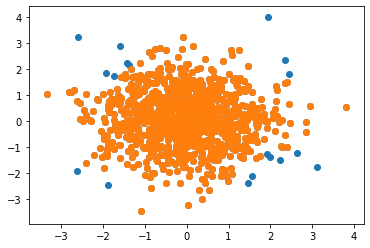

In [31]:
m_norm = MultivariateNormal(censored.loc, censored.covariance_matrix)
s = m_norm.sample([1000,])
filtered = truncated.phi_(s).nonzero(as_tuple=True)
plt.scatter(s[:,0], s[:,1])
plt.scatter(s[filtered][:,0], s[filtered][:,1])

In [25]:
rescale_loc = censored.loc @ emp_scale + emp_loc
rescale_var = censored.covariance_matrix @ emp_cov
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated covariance_matrix: ", rescale_var)
print("censored kl divergence: ", kl_divergence(m, M))
print("empirical kl divergence: ", kl_divergence(emp, M))

estimated mean:  tensor([0.1745, 0.1155])
estimated covariance_matrix:  tensor([[ 0.6384, -0.0211],
        [-0.0207,  0.6603]])
censored kl divergence:  tensor(1.8021)
empirical kl divergence:  tensor(1.8684)


In [111]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'kl_div_trunc': float,
    'var': int,
    'alpha': float,
}

store.add_table(args.table_name, schema)

for i in range(args.trials): 
    W = Uniform(-.5, .5)
    centroid = W.sample([args.d,])
    
    gt_loc = ch.zeros(args.d,)
#     gt_loc = Uniform(-1, 1).sample([1,])
    for var in range(1, args.var + 1):
        # create new dataset
        gt_cov = var * ch.eye(args.d)
        gt_dist = MultivariateNormal(gt_loc, gt_cov)
        samples = gt_dist.sample([args.samples])

        # right truncate at 0
        phi = oracle.Sphere(gt_dist.covariance_matrix, centroid, 10.0)

#         phi = oracle.Right_Distribution(Tensor([0.0, float('inf')]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)
        
        emp_loc = S.mean(0)
        emp_cov = cov(S)
        emp_scale = ch.from_numpy(sqrtm(emp_cov))
        
        emp_dist = MultivariateNormal(emp_loc, emp_cov)

        S_norm = (S - emp_loc) @ emp_scale.inverse()
        phi_norm = UnNorm_Sphere(gt_dist.covariance_matrix, phi.centroid, phi.radius, emp_loc, emp_cov)
#         phi_norm = oracle.Right_Distribution((phi.right - emp_loc) / (LA.eigvals(emp_scale).float()))

        print("censored...")
        censored = CensoredMultivariateNormal({'phi': phi_norm,
                                   'alpha': alpha,
                                    'batch_size': 100, 
                                    'num_samples': 100,
                                    'lr': 1e-1, 
                                    'epochs': 20})
        censored.fit(S_norm)


        rescale_loc = censored.loc @ emp_scale + emp_loc
        rescale_var = censored.covariance_matrix @ emp_cov
        censor_dist = MultivariateNormal(rescale_loc, rescale_var)
        
        print("truncated...")
        truncated = TruncatedMultivariateNormal({
                          'alpha': alpha,
                          'epochs': 20, 
                          'batch_size': 100, 
                          'num_samples': 100,
                          'step_lr': 500,
                          'lr': 1e-1}, 
                         store=store)
        truncated.fit(S)
#         rescale_loc = truncated.loc @ emp_scale + emp_loc
#         rescale_cov = truncated.covariance_matrix @ emp_cov
        rescale_loc = truncated.loc
        rescale_cov = truncated.covariance_matrix
        trunc_dist = MultivariateNormal(rescale_loc, rescale_cov)

        kl_trunc = float(kl_divergence(trunc_dist, gt_dist))
        kl_censor = float(kl_divergence(censor_dist, gt_dist))
        kl_emp = float(kl_divergence(emp_dist, gt_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored': kl_censor,
            'kl_div_trunc': kl_trunc,
            'var': var,
            'alpha': alpha,
        })
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

    
store.close()

censored...
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0399, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0314, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0245, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0090, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0144, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0046, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9642, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9371, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9315, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9208, grad_fn=<CopyBackwards>)
cov norm:

cov norm:  tensor(9.8059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3845, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0668, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0458, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0410, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.7774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7356, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7318, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7258, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7302, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3548, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0702, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0603, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0545, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0471, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0430,

cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9251, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9183, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8730, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8586, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8427, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8250, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8174, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7841, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3642, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9546, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9409, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8385, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8296, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7854, grad_

cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0396, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0296, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0281, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0370, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0180, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0127, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9331, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.884

cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0771, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0568, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0259, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0222, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0159, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9614, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.93

cov norm:  tensor(9.7748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7693, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3042, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0921, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0838, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0902, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0883, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0845, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0744, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0665, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0469, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0459, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0291, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0235, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9967, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7815, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7467, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2921, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0784, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0681, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0574, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0508, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0391, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0407, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0254, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8163, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7938, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3394, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0701, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0567, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0506, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0293, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0177, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0122, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8196, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8123, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7947, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3246, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0773, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0634, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551

cov norm:  tensor(9.9358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9207, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9219, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8519, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8263, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3490, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(10.0113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9183, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9066, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8902, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8409, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8333, grad

cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0452, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0412, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0432, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0440, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0509, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0594, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0478, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0250, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0212, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(10.0534, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0508, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0291, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0135, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0063, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0015, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0032, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.7959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3645, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0526, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0283, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0276, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0228, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9903, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8403, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7802, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3514, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0587, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0402, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0330, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0295, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0248,

cov norm:  tensor(9.9372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9176, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8112, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8112, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7905, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3692, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9485, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9181, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9106, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8526, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8046, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7732, grad_

cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0198, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9921, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8792, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8742, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8487, gr

cov norm:  tensor(10.0840, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0679, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0455, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0346, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0306, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9893, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8201, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7884, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3948, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0521, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0503, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0357, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0450, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0257, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0267, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0130, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8191, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8046, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7770, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7408, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3471, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0871, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0931, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0938, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0906, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0682,

cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9422, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9201, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9087, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8665, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8269, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4315, grad

cov norm:  tensor(10.0501, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0414, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0309, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0232, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9337, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9165, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8635, 

cov norm:  tensor(10.0525, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0346, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0272, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0120, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0123, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9502, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9288, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8837, 

cov norm:  tensor(10.0837, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0788, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0835, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0797, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0766, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0521, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0294, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9515, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9352, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7741, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3608, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0905, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0783, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0653, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0565, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0527, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0402, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0399, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0408, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0380, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.9045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8502, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8424, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8344, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8188, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7991, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3886, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0766, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0775, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0799, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0919, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0728,

cov norm:  tensor(9.9147, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8460, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8303, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7863, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7346, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4459, grad

cov norm:  tensor(9.9895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9642, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9406, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8355, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8284, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8279, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8263, grad_

cov norm:  tensor(10.0241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0114, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0031, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9497, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9402, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9176, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9086, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8968, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8418, g

cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0572, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0525, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0355, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0252, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0242, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0212, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0026, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7566, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3317, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0649, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0527, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0400, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0396, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0192, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8424, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8341, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8240, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3591, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0742, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0684, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781,

cov norm:  tensor(9.9248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8909, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8635, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8193, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7898, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3262, grad

cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9307, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9177, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9106, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8468, gra

cov norm:  tensor(10.0488, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0391, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0301, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0154, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0107, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0040, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0042, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9583, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.93

cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0592, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0467, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0329, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0240, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0185, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9500, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9421, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3642, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0754, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0736, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0786, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0735, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0759, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0474, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0424, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2889, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0592, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0589, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0496, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0424,

cov norm:  tensor(9.9114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8775, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8288, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3581, grad

cov norm:  tensor(10.0056, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8403, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8188, gra

cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0208, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0118, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9792, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9600, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9620, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9420, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9341, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9252, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8789, g

cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0719, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0709, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0625, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0572, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0201, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9775, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9624, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8032, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4013, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0717, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0606, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0339, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0278, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0121, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0041, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8445, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8342, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8219, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7736, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2922, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0758, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0855, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0836,

cov norm:  tensor(9.9362, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8539, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8427, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8356, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8395, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8258, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3621, grad

cov norm:  tensor(9.9781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9716, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9509, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9427, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9194, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8291, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8175, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7645, grad_

cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0407, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0311, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0280, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0121, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9273, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9118, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9081, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8886

cov norm:  tensor(10.0800, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0883, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0914, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0878, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0753, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0656, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0644, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0589, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0530, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0488, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0296, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0098, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9903, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9673, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9507, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8352, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4573, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0730, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0786, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0847, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0749, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0668, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0450, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0445, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8502, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8361, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8346, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3540, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0677, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0488, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0452, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0506,

cov norm:  tensor(9.9431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9260, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8913, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8004, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7733, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7699, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3653, grad

cov norm:  tensor(10.0109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8465, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8337, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8144, grad

cov norm:  tensor(10.0503, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0410, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0318, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0330, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0273, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9726, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9529, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9406, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9093, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8768

cov norm:  tensor(10.0719, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0552, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0479, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0527, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0484, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0488, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0190, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0104, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9792, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9693, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.8006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7650, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3048, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0828, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0693, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0295, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0165, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0136, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8649, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8406, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8150, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7969, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7641, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3567, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0671, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0729, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0713, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0746, 

cov norm:  tensor(9.9455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9187, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8893, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8742, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7716, grad_

cov norm:  tensor(10.0143, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0147, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0162, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0117, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9122, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9108, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8526, 

cov norm:  tensor(10.0441, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0396, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0271, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0226, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0183, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9872, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9259, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8801,

cov norm:  tensor(10.0852, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0821, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0842, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0772, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0516, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0366, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0281, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0161, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9336, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8057, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7827, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3270, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0607, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0699, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0603, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0384, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0287, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0208, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8440, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7962, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3910, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0730, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0715, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0630, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0642, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493,

cov norm:  tensor(9.9111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8513, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8413, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8156, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7843, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7679, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3006, grad

cov norm:  tensor(9.9920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9816, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8635, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8440, grad_

cov norm:  tensor(10.0177, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0104, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9563, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9445, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8789, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8604, gr

cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0636, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0461, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0380, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0298, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0184, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0078, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9806, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9478, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8177, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7826, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4620, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0574, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0546, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0269, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0223, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0227, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9843, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9673, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.95

cov norm:  tensor(9.8522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8356, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8255, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8266, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3647, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0835, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0805, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0575, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.036

cov norm:  tensor(9.8822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8579, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8291, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7565, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3866, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0795, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0838, g

cov norm:  tensor(9.9434, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9318, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9218, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8743, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8730, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8492, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8174, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7472, grad_

cov norm:  tensor(9.9898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9494, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9438, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9405, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9279, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8303, grad_

cov norm:  tensor(10.0517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0375, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0410, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0353, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0313, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0260, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9434, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9307, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9246, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8786

cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0560, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0458, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0302, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0180, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0070, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0002, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9485, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.92

cov norm:  tensor(9.7626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3154, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0741, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0763, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0634, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0574, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0574, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0358, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0328, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0125, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9777, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8352, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8274, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7886, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3791, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0755, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0755, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0704, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0615, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0406, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0298, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0206, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.9040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8464, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8254, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8262, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8250, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7957, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4086, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0896, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0805, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0850, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0831, g

cov norm:  tensor(9.9389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9193, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8341, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8223, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8122, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7627, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3066, grad

cov norm:  tensor(9.9820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9344, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9130, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9138, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8775, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8408, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8336, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8103, grad_

cov norm:  tensor(9.9975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9804, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9414, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8947, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8783, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8357, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8210, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8113, grad_

cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0244, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0290, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0318, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0217, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0029, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9335, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9002, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8711

cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0763, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0730, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0382, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0353, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0290, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0181, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0116, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9640, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.7672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7530, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3497, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0587, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0533, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0353, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0280, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0207, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0080, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8299, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8165, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8147, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3182, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0825, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0829, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0921, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0755, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0447, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0384, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8701, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8582, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8521, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8252, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7755, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7545, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3495, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0810, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0702, gr

cov norm:  tensor(9.9198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9150, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9090, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8943, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8804, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8583, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8491, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8266, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7914, grad_

cov norm:  tensor(9.9768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9701, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8701, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8312, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8043, grad_

cov norm:  tensor(10.0261, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0121, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0162, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0083, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0020, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9537, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9566, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9420, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9335, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8942, 

cov norm:  tensor(10.0842, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0832, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0764, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0636, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0491, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0404, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0232, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0054, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9788, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(9.8475, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8214, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4386, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0665, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0640, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0429, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0311, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0249, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0212, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8446, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7893, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3404, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0713, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0521, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.03

cov norm:  tensor(9.8592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8631, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8303, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8181, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7600, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3553, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0567, gr

cov norm:  tensor(9.9887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9472, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8529, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8207, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8083, grad_

cov norm:  tensor(9.9958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9631, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8470, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_

cov norm:  tensor(10.0597, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0312, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0335, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0273, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0206, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0137, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0128, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9383, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9169, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(10.0667, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0396, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0261, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0226, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0174, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9773, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7419, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7230, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2971, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0811, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0809, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0856, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0704, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0604, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0453, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0349, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8519, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8506, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8408, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8378, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8356, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8137, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7970, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4308, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0587, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0555, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0590, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0492,

cov norm:  tensor(9.9253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9186, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9002, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8262, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3918, grad

cov norm:  tensor(9.9719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9485, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9323, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8653, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8336, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8136, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8145, grad_

cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0321, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0118, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0056, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9272, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9163, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8847,

cov norm:  tensor(10.0817, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0717, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0398, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0338, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0158, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0153, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0123, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0055, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0070, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9843, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9694, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9533, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9516, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3085, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0679, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0565, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0459, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0469, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0407, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0383, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0451, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0440, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0458, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8393, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8207, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8080, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8066, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4657, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0581, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0468, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542,

cov norm:  tensor(9.9101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8604, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7359, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2729, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0783, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, gra

cov norm:  tensor(9.9399, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9388, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8804, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8564, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8492, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8144, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7965, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3495, grad

cov norm:  tensor(10.0011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8424, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8292, grad

cov norm:  tensor(10.0416, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0341, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0271, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0216, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9816, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9694, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9549, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9399, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9288, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8731,

cov norm:  tensor(10.0787, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0550, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0594, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0446, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0465, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0282, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0289, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0188, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9716, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9516, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9286, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7711, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7213, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3193, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0561, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0375, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0470, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0223, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9892, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8147, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7439, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3282, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0537, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0337, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0335,

cov norm:  tensor(9.8774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8628, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8427, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8077, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4206, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0829, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0851, gra

cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9142, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8783, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8509, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7509, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7336, grad_

cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8991, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8604, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8491, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8249, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8221, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8020, grad_

cov norm:  tensor(10.0710, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0525, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0384, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0366, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0285, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0242, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0174, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0102, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9230, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0387, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0340, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0195, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0212, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0124, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0060, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9771, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9786, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3364, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0767, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0978, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0859, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0888, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0913, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0881, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0861, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0415, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0305, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0171, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.8112, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8019, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7942, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3467, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0553, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0487, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0439, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0332, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0242, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3423, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0905, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0854, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0851, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683,

cov norm:  tensor(9.9285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9108, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8750, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8310, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7909, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2912, grad

cov norm:  tensor(10.0052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9570, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9296, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9174, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8673, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8674, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8519, grad

cov norm:  tensor(10.0747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0347, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0291, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0124, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0080, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9396, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9254, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8

cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0770, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0649, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0355, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0136, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9969, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9778, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.7488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7445, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3225, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0647, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0632, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0375, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0300, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0300, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0341, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0193, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3499, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0898, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0967, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1020, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1016, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0947, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0898, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0854, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0834, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0596, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8771, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8181, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8176, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8205, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8120, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3907, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0846, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0808, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0804, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0679, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0587,

cov norm:  tensor(9.9047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7977, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7650, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3677, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0726, gra

cov norm:  tensor(9.9461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9332, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9023, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8655, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8537, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8317, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7698, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7729, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3470, grad

cov norm:  tensor(9.9848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9355, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9338, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9154, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8445, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8321, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8130, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8151, grad_

cov norm:  tensor(10.0025, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9486, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9242, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9023, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8533, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8523, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8503, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8405, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8270, gra

cov norm:  tensor(10.0901, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0973, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0905, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0852, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0855, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0693, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0576, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0364, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0274, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0255, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9727, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(9.8048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7777, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7578, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3174, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0576, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0433, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0366, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0371, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0306, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0173, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8446, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8401, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8303, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7609, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3425, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542,

cov norm:  tensor(9.9004, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8771, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8360, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8116, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7658, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7612, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7352, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1940, grad

cov norm:  tensor(10.0056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9509, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8907, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8429, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8415, grad

cov norm:  tensor(10.0415, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0341, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0263, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9746, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9649, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9280, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9181, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9051, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8934, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8680, g

cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0656, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0443, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0350, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0223, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0198, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0181, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0199, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0098, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9535, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9317, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7913, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7734, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4094, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0692, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0775, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0819, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0746, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0519, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0391, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0353, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0191, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8265, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8153, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8147, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7810, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7647, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4090, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0642, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0349,

cov norm:  tensor(9.8522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8411, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7841, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7724, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7438, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7412, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3086, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0815, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, gr

cov norm:  tensor(9.9221, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8240, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8076, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3486, grad

cov norm:  tensor(10.0000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8787, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8701, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8516, grad

cov norm:  tensor(10.0333, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0221, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0180, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0169, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9368, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9203, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9242, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8884,

cov norm:  tensor(10.0798, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0692, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0759, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0754, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0441, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0452, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0382, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0190, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0176, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9921, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8187, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7746, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7668, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3628, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0671, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0499, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0404, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0447, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0394, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0346, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0357, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8570, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7942, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3474, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0567, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579,

cov norm:  tensor(9.9278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9142, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8586, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8391, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8279, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8221, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8211, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7904, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3286, grad

cov norm:  tensor(9.9851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9486, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9419, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9120, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8548, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8422, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7994, grad_

cov norm:  tensor(10.0710, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0557, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0379, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0210, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0131, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0082, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9315, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.88

cov norm:  tensor(10.0773, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0860, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0458, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0387, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0232, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0243, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9646, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3381, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0590, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0466, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0463, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0317, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0348, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0343, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0350, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8321, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8160, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7778, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7658, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3206, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0650, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0626, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0632, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0615, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0518,

cov norm:  tensor(9.9339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9193, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8607, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8422, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8203, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7840, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3220, grad

cov norm:  tensor(9.9944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9422, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8451, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8186, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8138, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7996, grad_

cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0396, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0371, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0380, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0152, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0102, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0079, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9804, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.88

cov norm:  tensor(10.0803, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0834, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0788, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0504, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0374, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0236, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0136, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9627, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3939, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0817, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0684, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0681, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0557, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0596, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8563, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8355, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8312, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8196, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7883, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2766, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0783, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0860, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0568,

cov norm:  tensor(9.8995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8798, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8733, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8656, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8422, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8338, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8369, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7755, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7783, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4033, grad

cov norm:  tensor(10.0056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9724, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9658, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9367, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9192, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9138, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9002, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8889, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8147, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8042, grad

cov norm:  tensor(10.0329, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0348, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0282, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0217, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0182, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0076, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9165, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8965

cov norm:  tensor(10.0911, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0964, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0807, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0841, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0913, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0584, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0337, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0207, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9909, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9252, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7863, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7821, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7745, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7612, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3345, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0452, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0448, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0267, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0284, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0181, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0125, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3622, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0901, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0911, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0860, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0838, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0776, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0675,

cov norm:  tensor(9.9411, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8725, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8478, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8367, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8023, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7792, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3624, grad

cov norm:  tensor(9.9960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9649, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9144, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8584, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_

cov norm:  tensor(10.0341, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0263, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0333, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0227, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0207, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0111, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0044, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9392, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8789, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.856

cov norm:  tensor(10.0780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0671, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0430, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0311, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0206, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0224, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0111, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0080, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0135, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0188, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0057, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0053, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0061, grad_fn=<CopyBackwards>)
cov norm:  t

cov norm:  tensor(9.8615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3789, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0728, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0456, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0451, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8879, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8386, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8246, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8258, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8039, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4700, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0784, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0752, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0655, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0434,

cov norm:  tensor(9.9763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9530, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9307, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8631, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8500, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7947, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2939, grad

cov norm:  tensor(10.0171, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0090, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9979, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9668, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9317, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9291, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8352, gra

cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0560, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0395, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0340, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0198, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9655, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9362, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9294, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.90

cov norm:  tensor(10.0761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0746, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0799, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0629, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0450, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0430, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0243, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0244, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0081, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0113, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9707, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8402, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8265, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8250, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4619, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0656, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0472, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0494, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0178, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0226, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0262, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8563, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8251, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8135, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8027, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3288, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0836, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0841, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0840, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0874, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0829, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740,

cov norm:  tensor(9.9029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8746, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8668, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8414, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8421, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8110, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3108, grad

cov norm:  tensor(9.9661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9605, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9360, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9250, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8614, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8433, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8347, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8238, grad_

cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0741, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0496, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0439, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0203, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0174, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9326, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9244, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.92

cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0528, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0479, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0210, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0102, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9346, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9342, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7604, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3220, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0891, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0821, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0809, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0769, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0657, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0509, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0471, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0362, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0212, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0145, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0168, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8656, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8637, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8473, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8402, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8371, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8150, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4090, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0466, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0435, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0382,

cov norm:  tensor(9.9203, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8921, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8361, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8094, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3238, grad

cov norm:  tensor(9.9243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9168, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8913, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8357, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8299, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8186, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7855, grad_

cov norm:  tensor(9.9672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9551, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9515, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9282, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8724, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8679, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8515, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8367, grad_

cov norm:  tensor(10.0263, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0096, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9359, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9352, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9207, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, g

cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0788, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0835, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0679, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0584, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0459, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0356, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0199, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0202, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0147, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9795, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3326, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0844, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0794, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0822, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0904, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0867, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0786, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0641, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0518, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0328, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8548, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7764, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3443, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0388, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0334, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0189,

cov norm:  tensor(9.9457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8359, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8262, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8192, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7981, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4063, grad

cov norm:  tensor(10.0218, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0274, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0227, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9396, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9266, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8794, 

cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0227, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0127, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0178, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0168, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9492, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9413, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9359, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9283, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8994,

cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0590, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0526, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0325, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0310, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0202, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9909, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9893, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7982, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4257, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0803, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0828, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0839, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0766, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0566, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0508, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0302, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8362, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8270, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7387, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7317, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3639, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0832, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0800, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0784, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0606, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0698,

cov norm:  tensor(9.9609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9473, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9112, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4498, grad

cov norm:  tensor(10.0163, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9584, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9478, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9192, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8806, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8461, gra

cov norm:  tensor(10.0382, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0175, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0272, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0215, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0095, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9943, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9548, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9342, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9028

cov norm:  tensor(10.0751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0582, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0249, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9637, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7937, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7878, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4002, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0758, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0410, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0174, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0187, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0091, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8355, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8272, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7903, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3273, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0667, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0707, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556,

cov norm:  tensor(9.9517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9120, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8833, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8783, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8509, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8383, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8386, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3887, grad

cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9188, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8833, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8291, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8156, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8081, grad_

cov norm:  tensor(10.0269, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0161, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0145, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8277, 

cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0871, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0858, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0728, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0656, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0607, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0467, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0367, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0251, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0153, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0171, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0114, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8219, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8106, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7977, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7969, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7868, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3274, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0802, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0555, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0572, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0594, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0597, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0380, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8263, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8118, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7733, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3405, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0857, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0890, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0763, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0767, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705,

cov norm:  tensor(9.9712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9070, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8778, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8620, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7933, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3802, grad

cov norm:  tensor(10.0192, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9862, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9318, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8677, gr

cov norm:  tensor(10.0424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0250, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0129, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9546, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9250, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9280, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8729, 

cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0693, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0729, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0533, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0561, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0390, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0248, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0177, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9433, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9357, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7440, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4079, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0634, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0488, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0325, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0189, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0082, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9862, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.97

cov norm:  tensor(9.8558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8475, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8406, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8200, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7862, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7530, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2995, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0471, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0313, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0218,

cov norm:  tensor(9.9447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8764, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8480, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8401, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8210, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8173, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3470, grad

cov norm:  tensor(9.9584, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9251, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9110, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8943, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8764, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8551, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8460, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8112, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7951, grad_

cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0362, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0095, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0046, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9475, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8583, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8340, 

cov norm:  tensor(10.0868, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0763, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0736, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0752, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0559, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0403, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9593, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8153, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7821, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3558, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0309, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0242, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0207, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0053, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8188, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7879, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4205, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0614, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0492, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0333,

cov norm:  tensor(9.8760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8646, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8616, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8512, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8375, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8257, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7810, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7716, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7583, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7227, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3321, grad

cov norm:  tensor(9.9759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9391, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9301, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8810, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8249, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8131, grad_

cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0440, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0347, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0209, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9902, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9668, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9418, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9344, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8876, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689,

cov norm:  tensor(10.0815, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0876, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0828, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0826, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0704, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0307, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0267, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0158, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0061, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9693, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.7925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3584, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0545, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0472, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0394, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0324, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0229, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0255, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8360, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8194, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8154, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3319, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0704, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0702, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0754, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0411,

cov norm:  tensor(9.9493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9385, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9158, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9108, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8655, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8579, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7902, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7711, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2602, grad

cov norm:  tensor(9.9604, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9265, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9108, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8272, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8137, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8016, grad_

cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0491, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0452, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0528, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0343, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0321, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0151, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9254, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.89

cov norm:  tensor(10.0473, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0499, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0459, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0334, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0251, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0146, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0135, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0138, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0013, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9310, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8020, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3769, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0863, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0759, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0709, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0589, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0525, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0395, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8584, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8165, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7892, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7860, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2299, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0749, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0521, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0466, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0443, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0314,

cov norm:  tensor(9.9040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8919, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8614, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8434, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8259, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8148, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7782, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7472, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2736, grad

cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0057, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0053, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0019, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9411, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9138, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9086, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8843, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8778, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8603, g

cov norm:  tensor(10.0581, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0371, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0180, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0151, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0091, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9872, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9502, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9408, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9294, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9225, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.90

cov norm:  tensor(10.0864, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0812, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0908, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0755, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0729, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0519, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0407, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0312, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0161, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0031, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9801, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7733, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3276, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0681, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0719, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0681, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0385, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0412, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8427, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8156, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7640, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3021, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0665, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0630, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0480,

cov norm:  tensor(9.9223, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8653, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8272, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8191, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8116, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3434, grad

cov norm:  tensor(9.9781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9120, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8943, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8396, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8057, grad_

cov norm:  tensor(10.0576, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0159, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0120, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9417, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9310, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9221, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9085, 

cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0518, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0460, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0266, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0274, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9974, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9636, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7847, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2926, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0746, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0768, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0546, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0505, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0509, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7907, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3061, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0373,

cov norm:  tensor(9.9077, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8371, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8395, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3805, grad

cov norm:  tensor(9.9894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9889, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9560, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9519, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9486, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8502, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8453, grad_

cov norm:  tensor(10.0539, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0568, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0499, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0352, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0279, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0208, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9833, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9370, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8746

cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0633, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0406, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0264, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0193, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0150, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0043, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9642, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.7399, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2072, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0798, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0494, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0354, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0375, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0245, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0153, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0089, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9999, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0041, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.7792, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7572, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3589, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0829, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0889, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0831, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0651, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0649, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0450, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0436, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8560, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8480, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8423, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8201, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8046, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3314, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0717, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0749, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0603,

cov norm:  tensor(9.9283, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9240, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8254, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7786, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3592, grad

cov norm:  tensor(9.9493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9440, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9485, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9359, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9219, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9194, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8892, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8521, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8093, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8076, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7870, grad_

cov norm:  tensor(9.9458, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9163, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8997, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8750, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8627, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8617, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8465, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8347, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8240, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7885, grad_

cov norm:  tensor(9.9919, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9530, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9399, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9250, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9066, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8600, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8303, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8142, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7807, grad_

cov norm:  tensor(10.0251, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0186, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0191, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0181, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0124, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9617, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9636, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8939,

cov norm:  tensor(10.0644, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0573, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0414, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0287, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0256, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0190, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9782, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7472, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2793, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0688, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0401, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0255, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0232, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0047, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8231, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7539, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7496, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3947, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0456, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486,

cov norm:  tensor(9.9157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9004, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8486, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7787, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7659, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7160, grad_

cov norm:  tensor(9.9846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9530, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9331, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7923, grad_

cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0206, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0292, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0259, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0170, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0095, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9393, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.87

cov norm:  tensor(10.0906, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0939, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0784, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0822, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0597, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0398, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0224, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0178, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0043, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9616, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9273, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8104, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4221, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0583, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0499, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0191, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0176, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0225, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0116, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0103, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9759, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7790, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3552, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0668, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0572, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0557, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0309, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0228, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0213, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0200, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0149, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0086, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0014, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8118, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7527, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3553, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0305,

cov norm:  tensor(9.9512, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9409, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9274, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8879, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8391, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8090, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7733, grad_

cov norm:  tensor(9.9682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9564, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9422, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9032, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9013, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8315, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8175, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8055, grad_

cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0330, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0281, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9969, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9921, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9675, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9764, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9530, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9406, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9332, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9265,

cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0612, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0491, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0205, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0082, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9642, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9636, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.7855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3800, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0773, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0329, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0278, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0254, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0122, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7786, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3667, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0606, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0526, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0371, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0311, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0191, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0150, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0086, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0142, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0144, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0146, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0070, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8439, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8284, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8057, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7545, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3269, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0699, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0510, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0515, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.035

cov norm:  tensor(9.9040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8641, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8539, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8403, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8223, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8191, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7653, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3538, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, gra

cov norm:  tensor(9.9073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8417, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8282, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7406, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2329, grad

cov norm:  tensor(9.9915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9258, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9168, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8616, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8341, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8086, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7973, grad_

cov norm:  tensor(9.9957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9656, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9418, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9258, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9254, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9256, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8806, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8659, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8407, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8330, grad_

cov norm:  tensor(10.0799, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0677, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0581, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0455, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0356, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0407, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0242, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0104, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9188, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8257, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8160, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3958, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0871, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0823, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0803, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0859, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0793, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0644, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0508, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0369, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8388, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8347, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3535, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0923, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0918, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0853, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0880, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0858,

cov norm:  tensor(9.8976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8282, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8070, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7694, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3163, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0728, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, gra

cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8725, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8635, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8458, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8118, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8093, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7815, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4268, grad

cov norm:  tensor(10.0103, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0023, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9509, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8979, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8907, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8787, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8521, gra

cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0472, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0348, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0205, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9632, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9636, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8779,

cov norm:  tensor(10.0776, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0906, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0926, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0478, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0301, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0203, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0145, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9519, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9315, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8115, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4081, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0710, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0430, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0326, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0155, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8315, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8360, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3746, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0809, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0664, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0615, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0583, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0377, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.04

cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8789, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8745, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8628, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8076, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7629, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4329, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, gra

cov norm:  tensor(9.9802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9777, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9566, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9521, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9445, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8843, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8307, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7885, grad_

cov norm:  tensor(9.9952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9778, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9473, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8360, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8217, grad_

cov norm:  tensor(10.0369, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0334, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0153, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0099, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0131, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0054, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0060, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0046, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9632, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.865

cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0317, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0297, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0201, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9387, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9205, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8979,

cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0484, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0403, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0394, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0278, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9903, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9659, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.7895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7742, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2909, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0829, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0641, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0642, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0655, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0288, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0225, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8607, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8439, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8211, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7775, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3676, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0349, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0311, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0382,

cov norm:  tensor(9.9281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8405, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8171, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4210, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(10.0090, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9279, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9122, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8385, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8193, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7816, grad

cov norm:  tensor(10.0306, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0165, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9889, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9250, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8381, gr

cov norm:  tensor(10.0799, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0535, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0513, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0338, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0186, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0152, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9919, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9419, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9401, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9399, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.91

cov norm:  tensor(10.0715, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0734, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0843, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0948, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0852, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0660, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0590, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0634, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0491, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0370, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0325, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0198, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0201, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0127, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9916, grad_fn=<CopyBackwards>)
cov norm:  te

cov norm:  tensor(9.7787, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7458, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4424, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0742, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0655, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0545, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0432, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0377, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8365, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8365, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8274, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8249, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8019, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3496, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0804, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0815, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0501, 

cov norm:  tensor(9.9107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9128, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8453, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8429, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8277, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8257, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8168, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3143, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9862, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9328, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9218, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8655, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8393, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8179, grad_

cov norm:  tensor(10.0201, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0235, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9755, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9612, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9383, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9087, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8685, gr

cov norm:  tensor(10.0803, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0779, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0807, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0650, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0550, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0632, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0692, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0583, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0595, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0439, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0381, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0259, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0225, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0246, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0125, grad_fn=<CopyBackwards>)
cov norm:  t

cov norm:  tensor(9.7534, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3239, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0480, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0528, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0416, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0459, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0338, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0171, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9913, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8027, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7851, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4054, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0730, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0633, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0582, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0463, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0334, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0218, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0258, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7584, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3284, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0506, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0400, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0451, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0356,

cov norm:  tensor(9.9610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9205, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7773, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3741, grad

cov norm:  tensor(9.9911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9641, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9344, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9279, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8733, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8187, grad_

cov norm:  tensor(10.0417, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0508, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0361, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0317, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0330, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0352, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0146, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9336, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8

cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0713, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0388, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0184, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0138, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0111, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.7812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7673, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7644, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3409, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0825, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0753, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0704, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0377, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0244, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0244, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0153, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0100, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0136, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8467, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8357, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8205, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8023, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7903, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7864, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3987, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0957, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0857, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0792, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0644, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0681, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0614,

cov norm:  tensor(9.8773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8631, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8445, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8187, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7464, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7411, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3099, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0813, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0950, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0911, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0897, g

cov norm:  tensor(9.9048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8989, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8470, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8480, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8361, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8427, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8051, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3870, grad

cov norm:  tensor(9.9562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9553, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8637, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8563, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8460, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8124, grad_

cov norm:  tensor(10.0478, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0326, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9968, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8697, 

cov norm:  tensor(10.0931, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0892, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0931, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0879, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0582, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0594, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0381, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0223, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0180, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9826, grad_fn=<CopyBackwards>)
cov norm:  te

cov norm:  tensor(9.7687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7526, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3798, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0736, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0753, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0824, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0290, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0320, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9982, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7679, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7345, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7323, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7232, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3574, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0433, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0236, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0172, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.

cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8240, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7876, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7429, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3634, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0779, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0754, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0808, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0615, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608,

cov norm:  tensor(9.9007, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8402, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7724, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7182, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7098, grad_

cov norm:  tensor(9.9701, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9465, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9424, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9414, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8548, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8550, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_

cov norm:  tensor(10.0276, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0196, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0209, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0232, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0213, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0136, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0153, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9497, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9171, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.87

cov norm:  tensor(10.0849, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0775, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0357, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0168, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0207, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9551, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7463, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2520, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0952, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1085, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1104, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1012, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0943, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0861, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0839, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0852, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0821, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0817, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8375, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8260, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8259, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7875, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3458, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0677, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0574, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0651, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0630, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.015

cov norm:  tensor(9.9435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9242, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9191, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9136, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8323, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8210, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8160, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3533, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0811, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, gra

cov norm:  tensor(9.9916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9413, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9228, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9080, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8315, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8096, grad_

cov norm:  tensor(10.0269, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0191, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0111, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9781, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9370, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9258, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9169, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8584, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8421, g

cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0390, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0257, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0257, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0260, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0092, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9347, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9318, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.92

cov norm:  tensor(10.0837, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0865, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0871, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0457, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0305, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9546, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9349, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.7525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7346, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7193, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7132, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3720, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0750, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0616, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0479, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0282, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8344, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8153, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8148, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7929, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3295, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0900, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0879, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0865, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0831, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0758, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.075

cov norm:  tensor(9.8985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8385, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7560, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7386, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3388, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9968, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9632, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9627, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9537, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8816, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8632, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8525, grad_

cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0383, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0288, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9607, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9352, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8782, g

cov norm:  tensor(10.0541, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0557, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0480, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0406, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0582, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0326, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0318, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0266, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0259, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0213, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9462, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7560, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2730, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0715, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0558, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0709, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0552, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0290, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8299, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2872, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0794, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0833, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0840, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0830, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0764, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0649, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.05

cov norm:  tensor(9.8551, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8546, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8192, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2671, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0684, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0621, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540

cov norm:  tensor(9.9198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8537, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8177, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8153, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8009, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4400, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0557, grad

cov norm:  tensor(9.9618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8570, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8513, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8257, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7657, grad_

cov norm:  tensor(9.9389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9152, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8739, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8726, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8616, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8583, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8080, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7766, grad_

cov norm:  tensor(10.0337, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0220, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9417, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9440, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9158, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8968, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8860, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8720, gr

cov norm:  tensor(10.0898, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0882, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0967, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0969, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0895, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0876, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0451, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0191, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9726, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9526, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(10.3086, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0834, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0824, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0835, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0800, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0516, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0436, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0373, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0297, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0224, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0113, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9688, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.8244, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7969, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2649, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0749, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0800, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0641, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0604, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0379, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0402, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0203, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0091, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3982, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0657, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0566, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0555, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0455, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0373, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0221, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.

cov norm:  tensor(9.8631, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7816, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7497, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2677, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0810, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0644, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0546, g

cov norm:  tensor(9.9108, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8537, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8187, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8264, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8291, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8169, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8120, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7904, grad_

cov norm:  tensor(9.9991, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9616, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9550, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9404, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9254, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8181, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8317, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8255, grad_

cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0612, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0595, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0480, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0373, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0184, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0081, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0144, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9492, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8

cov norm:  tensor(10.0671, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0459, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0400, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0195, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0078, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9968, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9674, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9345, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.93

cov norm:  tensor(9.7621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7491, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2774, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0415, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0341, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0336, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0164, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0109, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9945, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8331, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8307, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4133, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0930, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0938, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0836, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0964, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0788, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0578, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0501, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0480, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.

cov norm:  tensor(9.8859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8617, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8470, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8303, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7430, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2702, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0884, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0846, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0640, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670,

cov norm:  tensor(9.9159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9032, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8312, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8054, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7989, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7975, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3646, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0752, grad

cov norm:  tensor(9.9761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9600, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9385, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9123, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9027, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8512, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7991, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7788, grad_

cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8770, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8694, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8636, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8210, grad

cov norm:  tensor(10.0565, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0565, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0447, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0311, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0166, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0120, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9688, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9203, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.90

cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0473, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0301, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0227, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.92

cov norm:  tensor(9.7653, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3140, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0642, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0625, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0530, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0338, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0198, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0105, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0070, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9968, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9819, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8183, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8110, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7812, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4052, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0902, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1036, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1100, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0976, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0952, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0857, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0839, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0768, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.06

cov norm:  tensor(9.8962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8659, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8118, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7775, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7673, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3434, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, gra

cov norm:  tensor(9.9919, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9628, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9472, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9395, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9360, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8782, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8745, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8260, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8023, grad_

cov norm:  tensor(9.9918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8469, grad_

cov norm:  tensor(10.0249, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0244, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0107, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0038, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9783, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9403, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9148, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, 

cov norm:  tensor(10.0693, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0717, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0597, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0387, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0300, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0210, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0137, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9862, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3622, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0827, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0737, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0734, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0615, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0323, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0258, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0300, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0340, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0394, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0200, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9989, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.8372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8323, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7924, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3191, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0518, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0582, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0441, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0359, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0294, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0269, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8446, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8221, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7515, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2905, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0702, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0664, gr

cov norm:  tensor(9.9651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9539, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9331, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9203, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8018, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4298, grad

cov norm:  tensor(9.9762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9230, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9076, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8023, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7916, grad_

cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0369, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0346, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0249, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0225, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0174, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0151, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0057, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9548, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9391, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.90

cov norm:  tensor(10.0944, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0927, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0692, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0575, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0365, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0278, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0127, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0148, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9406, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8182, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8070, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7897, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3800, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0882, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0863, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0630, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0611, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0578, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0558, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0511, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0494, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.9033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8789, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8355, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8365, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8454, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8182, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4009, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0834, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0926, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0889, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0754, g

cov norm:  tensor(9.9249, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9193, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8806, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8730, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8516, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8342, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8171, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7977, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7865, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4055, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0873, grad

cov norm:  tensor(9.9818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9617, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9650, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9168, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8764, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8122, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8066, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8041, grad_

cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0125, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9513, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9344, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8943, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8550, gr

cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0273, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0222, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0112, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9317, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8821, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8790, 

cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0561, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0453, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0251, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0125, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0084, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0090, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0019, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8201, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7838, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4097, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0798, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0783, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0806, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0911, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0814, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0826, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0828, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0737, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0612, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0453, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0360, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8310, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8269, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8270, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8156, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7872, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3305, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0408, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.028

cov norm:  tensor(9.9339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9280, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8411, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7921, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7919, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3038, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0771, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0735, gra

cov norm:  tensor(9.9442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9421, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8409, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7989, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7889, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7789, grad_

cov norm:  tensor(10.0134, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9706, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9548, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8367, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8211, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8239, gra

cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0584, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0406, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0299, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0307, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9819, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9635, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9218, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.903

cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0829, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0763, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0775, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0604, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0380, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0335, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0273, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9815, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9726, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.8149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8059, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3555, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0857, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0948, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1030, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0876, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0919, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0938, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1005, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0899, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0587, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0510, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0371, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0245, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8375, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8294, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3983, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0641, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0576, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0496, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0469, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0527

cov norm:  tensor(9.8908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8446, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8402, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8361, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8280, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8225, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3062, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9775, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9138, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9002, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8361, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8091, grad_

cov norm:  tensor(10.0280, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0102, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8843, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8267, g

cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0466, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0634, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0650, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0589, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0561, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0394, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0280, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0243, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0155, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0173, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0049, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0093, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9714, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(10.2654, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0252, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0169, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9730, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7755, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7605, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3539, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0924, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0903, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0926, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0859, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0807, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0786, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0693, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.9516, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8675, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8492, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2765, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0810, gra

cov norm:  tensor(9.9699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9448, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9331, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9269, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9283, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8418, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8323, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8073, grad_

cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0391, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0281, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0230, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0083, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9513, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9485, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9355, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9221, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8949

cov norm:  tensor(10.0650, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0629, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0735, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0412, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0366, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0235, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0228, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0130, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0113, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9639, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7637, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3346, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0974, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0912, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0928, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0997, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0892, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0975, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0981, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0784, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0668, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0632, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0596, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0639, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7614, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3613, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0842, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0822, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0455, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0299, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0141, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7843, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7641, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7579, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7499, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3744, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0850, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0802, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0814, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0814, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0763, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0702, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.06

cov norm:  tensor(9.8585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8196, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7876, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7872, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7716, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7592, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3266, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0843, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0806, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0838, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0784,

cov norm:  tensor(9.8901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8907, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8771, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8566, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8259, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8150, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8160, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8051, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7743, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7559, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3512, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0829, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0932, gra

cov norm:  tensor(9.9474, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9328, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8573, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8549, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8163, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7921, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_

cov norm:  tensor(9.9832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8451, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8395, grad_

cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0252, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0208, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0091, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9706, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9563, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9438, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9150, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8514,

cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0684, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0222, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0171, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9798, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9713, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(10.3874, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0653, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0611, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0566, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0527, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0609, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0178, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0254, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0206, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0067, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0044, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9897, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7600, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3018, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0641, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0692, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0701, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0589, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0436, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0380, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0327, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0214, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9915, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9848, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8252, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8118, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7773, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3423, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0395, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0430, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.9129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8441, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8407, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7997, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7986, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3731, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0625, gra

cov norm:  tensor(9.9390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9196, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9168, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9264, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7860, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7925, grad_

cov norm:  tensor(10.0474, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0438, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0257, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9465, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9301, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9152, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8614, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8492, 

cov norm:  tensor(10.0904, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0892, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0851, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0931, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0871, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0812, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0581, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0501, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0396, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0309, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0131, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9937, grad_fn=<CopyBackwards>)
cov norm:  te

cov norm:  tensor(10.3892, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0509, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0451, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0467, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0508, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0513, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0488, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0377, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0229, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0138, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0104, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9642, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8279, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8062, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4253, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0835, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0767, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0574, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0445, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0213, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0189, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0248, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8407, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8244, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8127, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7497, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3546, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0730, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0677, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0609, g

cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8977, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8943, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8460, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8137, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7963, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3282, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9342, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9177, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9116, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8635, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8497, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8362, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_

cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0436, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0376, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0313, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0260, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0189, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9327, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9249, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8732

cov norm:  tensor(10.0728, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0750, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0558, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0283, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0207, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9969, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9726, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7653, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3202, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0731, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0447, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0440, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0525, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0357, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8296, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7942, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3740, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0664, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0616, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0601, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0504, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.05

cov norm:  tensor(9.9235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9183, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9138, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8605, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8147, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8144, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7810, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7734, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3200, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0739, grad

cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9391, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9211, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8733, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8474, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8230, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8067, grad

cov norm:  tensor(10.0229, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0183, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9804, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9460, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9423, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9225, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8860, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8722, g

cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0283, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0084, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0007, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9537, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9454, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9347, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9191, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8740, g

covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0625, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0460, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0302, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0236, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0088, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0086, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9983, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9674, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7895, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4516, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0806, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0771, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0782, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0633, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0535, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0441, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0367, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0315, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0105, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0023, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7458, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7487, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3660, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0855, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0640, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0614, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0428, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8467, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8177, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2443, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0626, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0511, gra

cov norm:  tensor(9.9491, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9383, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9174, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8414, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8266, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7582, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7501, grad_

cov norm:  tensor(10.0015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9726, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9632, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9349, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9201, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8379, grad

cov norm:  tensor(10.0097, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0076, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0011, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0021, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9742, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9698, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9441, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9458, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9383, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8969, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8892, 

cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0750, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0783, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0837, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0584, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0445, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0385, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0280, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0296, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0287, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0188, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0112, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9851, grad_fn=<CopyBackwards>)
cov norm:  te

cov norm:  tensor(10.3772, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0832, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0813, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0819, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0768, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0812, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0458, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0414, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0295, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0173, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9878, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8327, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8135, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7869, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4738, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0777, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0630, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0505, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0403, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0194, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8491, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8246, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8219, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7879, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7743, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7657, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2636, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0867, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0895, gra

cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9475, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8733, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8725, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8251, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7771, grad_

cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0385, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0268, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0164, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9644, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9136, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8598,

cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0239, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9746, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9688, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9464, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9339, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353,

cov norm:  tensor(10.0966, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0937, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0942, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1002, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1115, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1053, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0970, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0870, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0656, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0653, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0383, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9858, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(10.4248, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0817, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0775, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0636, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0606, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0411, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0227, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0247, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0190, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0145, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0058, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(9.8374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8244, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7870, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4547, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0869, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0864, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0852, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0868, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0792, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0395, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8860, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8244, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8128, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7497, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2394, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, gra

cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9771, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9642, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9338, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9255, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8889, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8782, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8637, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8584, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8120, grad_

cov norm:  tensor(10.0026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9716, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9539, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9249, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8529, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8416, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8100, grad

cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0515, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0331, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0264, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0172, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.895

cov norm:  tensor(10.0799, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0677, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0505, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0383, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0330, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0196, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9976, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0009, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0064, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9724, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9682, grad_fn=<CopyBackwards>)
cov norm:  tensor(

covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0567, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0399, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0391, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0283, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0277, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0148, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0163, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0078, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9530, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(10.3597, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0535, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0430, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0290, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0242, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0128, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0131, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9639, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8078, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4141, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0480, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0448, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0511, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8027, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7810, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3693, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0846, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0947, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0889, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0841, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0769, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0621, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.05

cov norm:  tensor(9.8768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8336, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8182, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8120, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4019, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0855, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0807, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0673, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0557, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500

cov norm:  tensor(9.8749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8612, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8416, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8277, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8125, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7833, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7719, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2818, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0812, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, gra

cov norm:  tensor(9.9088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8815, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8635, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8344, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8156, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7719, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3847, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(10.0108, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0116, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9879, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9409, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9303, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8392, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8199, gr

cov norm:  tensor(10.0573, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0515, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0323, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0337, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0303, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0131, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0106, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9977, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9794, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9328, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0581, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0630, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0568, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0457, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0309, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0362, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0235, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0260, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9456, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3592, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0758, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0872, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0811, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0468, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0467, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0118, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8755, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8392, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8130, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8186, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3264, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0595, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0581, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0606,

cov norm:  tensor(9.9047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8644, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8551, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7628, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3440, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9494, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9385, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9060, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8743, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8310, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8163, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8054, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7966, grad_

cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0653, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0630, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0527, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0248, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9474, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9368, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8936

cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0576, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0318, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0380, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0362, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0390, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0318, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0188, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0087, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9685, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3706, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0813, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0558, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0629, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0390, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0384, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0266, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0152, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8472, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8420, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8070, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3476, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0760, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0559, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0484,

cov norm:  tensor(9.9092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9080, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8764, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8454, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8423, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7989, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7859, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4550, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0889, grad

cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9451, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9323, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9337, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9250, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9130, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9200, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8560, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8387, grad_

cov norm:  tensor(9.9624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9087, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8640, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8387, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7989, grad_

cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0223, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0247, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0168, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0038, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0096, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9711, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9464, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9283, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8

cov norm:  tensor(10.0826, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0889, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0662, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0459, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0247, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9989, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9777, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9423, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9240, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.7990, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7441, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3006, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0665, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0734, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0664, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0552, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0435, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0348, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0276, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9991, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8375, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7683, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7519, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3573, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0962, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0980, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0954, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0902, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0832, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643

cov norm:  tensor(9.8665, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8183, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8051, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7612, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4260, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0684, grad

cov norm:  tensor(9.9075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9077, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9076, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8321, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8246, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8148, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7816, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7408, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7347, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4185, grad

cov norm:  tensor(9.9907, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9688, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9628, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9440, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8473, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_

cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0173, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9913, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9605, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9135, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8617, 

cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0537, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0484, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0212, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0158, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0100, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9981, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9533, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9492, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7903, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7658, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7704, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3108, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0491, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0381, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0377, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0267, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0192, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0218, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8007, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7615, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7503, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7433, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3282, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0597, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0496, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0499, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0433, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8564, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8352, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8391, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8263, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8138, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3601, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0836, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0861, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0911, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0904, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0845, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0713, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654

cov norm:  tensor(9.9630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9515, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9312, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9259, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8150, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8094, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7972, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8044, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7923, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3656, grad

cov norm:  tensor(9.9831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9296, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8441, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8125, grad_

cov norm:  tensor(10.0208, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0199, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9337, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9330, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9246, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8556, g

cov norm:  tensor(10.0684, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0513, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0561, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0342, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0365, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0217, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9433, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7764, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3740, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0710, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0429, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0284, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0249, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0171, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0090, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0078, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8679, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7620, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3963, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0487, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0382, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0395,

cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9500, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9150, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8913, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8506, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8429, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8303, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7943, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7943, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3996, grad

cov norm:  tensor(9.9395, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9256, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9142, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8494, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8439, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8341, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7993, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7725, grad_

cov norm:  tensor(10.0239, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0107, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9665, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9295, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8778, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8745, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8704, gr

cov norm:  tensor(10.0831, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0815, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0812, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0749, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0845, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0875, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0798, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0736, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0505, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0275, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9655, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9552, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(10.3340, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0409, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0388, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0291, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0330, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0401, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0271, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0305, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0295, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0271, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0106, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0098, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0078, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(9.7845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7620, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3490, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0779, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0656, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0642, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0515, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0361, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0236, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0224, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8424, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7726, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7603, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3498, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0819, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0607, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0372

cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8386, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8147, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7549, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7413, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2911, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9298, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9259, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9211, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8612, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8473, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8266, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8231, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8256, grad_

cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0443, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0268, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0143, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0038, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9892, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9792, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9741, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9512, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8659, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8523,

cov norm:  tensor(10.0936, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0862, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0849, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0782, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0744, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0681, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0578, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0263, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9872, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9583, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7573, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3991, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0621, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0450, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0435, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0307, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9764, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8013, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3766, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0541, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0510, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0435, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0326, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0352, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0338, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0177, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8912, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8445, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8418, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8291, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8098, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3738, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0402, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0321, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0114,

cov norm:  tensor(9.9366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9148, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8186, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8135, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7862, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3594, grad

cov norm:  tensor(9.9907, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9688, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9218, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8546, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8106, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_

cov norm:  tensor(10.0701, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0587, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0461, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0365, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0340, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0192, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9420, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9076, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8

cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0717, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0773, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0782, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0402, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0148, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8391, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8392, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8242, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7921, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3595, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0616, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0828, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0729, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0505, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0575, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0833, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8438, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8205, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7934, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8019, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3873, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0804, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0611,

cov norm:  tensor(9.9264, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8739, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8312, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7771, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7636, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7414, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7383, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7090, grad_

cov norm:  tensor(9.9839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9705, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9551, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9367, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8060, grad_

cov norm:  tensor(10.0758, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0389, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0289, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0222, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0064, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9841, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9472, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9414, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(10.0936, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0881, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0567, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0376, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0410, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0356, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0245, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0252, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0165, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0111, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9947, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9891, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7698, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7601, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3127, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0607, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0624, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0518, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0471, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0399, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0222, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8535, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8004, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7862, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4456, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0717, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0421, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0371, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0289, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.02

cov norm:  tensor(9.9136, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8399, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8228, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8192, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8196, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8171, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4203, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0509, gr

cov norm:  tensor(9.9228, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8494, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8401, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8128, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7728, grad_

cov norm:  tensor(10.0050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9620, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9409, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9312, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9182, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9175, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9112, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8876, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8378, grad

cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0309, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0214, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0268, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0176, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0134, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9560, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9513, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9453, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9020, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9093, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.902

cov norm:  tensor(10.0755, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0823, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0860, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0821, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0883, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0803, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0650, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0489, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0382, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0280, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0151, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0123, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0093, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9861, grad_fn=<CopyBackwards>)
cov norm:  te

cov norm:  tensor(9.7830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3395, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0429, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0096, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0096, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0085, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0106, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0081, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0046, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8321, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7746, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3726, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0768, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0704, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.056

cov norm:  tensor(9.8836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8368, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8201, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7777, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3282, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0465, gr

cov norm:  tensor(9.9206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8370, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8203, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8115, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8089, grad_

cov norm:  tensor(10.0156, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0159, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0046, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9810, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9405, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8910, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8586, gr

cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0414, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0367, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0306, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0177, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0054, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0125, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9706, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8867, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.873

cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0614, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0516, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0539, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0479, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0338, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0295, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0310, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0193, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0239, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0170, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0116, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9931, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9828, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3668, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0717, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0606, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0721, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0657, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0566, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0441, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0323, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0210, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0085, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8186, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8115, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7879, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3737, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0673, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0673, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.063

cov norm:  tensor(9.8784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8386, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8170, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8148, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7414, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4146, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0688, gra

cov norm:  tensor(9.9778, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9748, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9207, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8852, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8770, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8408, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8079, grad_

cov norm:  tensor(9.9672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9573, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8378, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8171, grad_

cov norm:  tensor(10.0647, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0515, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0407, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0297, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0098, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9789, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9777, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9384, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.90

cov norm:  tensor(10.0830, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0765, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0737, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0466, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0373, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0305, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0326, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0311, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0172, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0142, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0058, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0033, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9854, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(9.8040, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4343, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0853, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0802, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0752, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0601, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0552, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0479, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0404, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0469, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0434, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0377, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0194, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0129, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8399, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8288, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8061, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3267, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0592, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0374, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0267, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0115, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9698, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8396, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8293, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7997, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7835, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3918, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0710, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0795, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0760, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0769, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.066

cov norm:  tensor(9.8601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3335, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0573, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0604, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0555, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0465, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0423,

cov norm:  tensor(9.8950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8798, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8356, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8329, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3214, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0858, grad

cov norm:  tensor(9.9692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9649, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9393, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9258, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9137, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8466, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8360, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7897, grad_

cov norm:  tensor(10.0440, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0296, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0185, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0025, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8645, 

cov norm:  tensor(10.0889, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0946, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0936, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0967, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0881, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0864, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0835, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0230, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0103, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0143, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9992, grad_fn=<CopyBackwards>)
cov norm:  te

cov norm:  tensor(10.4374, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0699, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0445, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0320, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0355, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0169, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0170, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0137, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0108, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9725, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7314, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3332, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0800, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0865, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0932, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0882, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0861, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0516, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.9021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8947, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8770, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8356, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8080, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3242, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, gra

cov norm:  tensor(9.9877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9841, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9465, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9291, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9160, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9087, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8872, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8440, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8321, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8219, grad_

cov norm:  tensor(10.0154, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9893, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9777, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9519, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9367, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9136, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8919, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8581, gra

cov norm:  tensor(10.0731, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0655, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0478, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0441, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0325, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0327, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0140, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9913, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9716, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7582, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3238, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0553, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0373, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0267, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0257, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0092, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0186, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0116, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0007, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0008, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8545, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8262, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8156, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8007, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7957, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4339, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0784, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0762, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0387, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0346

cov norm:  tensor(9.9248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9183, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8186, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7811, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3950, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0761, grad

cov norm:  tensor(9.9152, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9019, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8739, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8752, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8445, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8370, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7798, grad_

cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9516, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9404, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9121, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8991, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8862, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8724, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8191, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8158, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7937, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7771, grad_

cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0417, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0275, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0039, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0057, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9521, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9347, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8833, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8750, 

cov norm:  tensor(10.0820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0728, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0731, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0744, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0406, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0287, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0129, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9937, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9564, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7765, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3359, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0607, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0578, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0471, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0317, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0253, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0284, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7742, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7496, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7473, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7455, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3720, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0872, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0874, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0735, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580

cov norm:  tensor(9.8866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8784, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8661, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7337, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7307, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3494, grad

cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9509, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9411, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9420, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9280, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8367, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7803, grad

cov norm:  tensor(10.0241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0143, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9845, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9714, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9426, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9197, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8739, gr

cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0467, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0496, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0429, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0172, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0222, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0152, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0052, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9937, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9777, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9656, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9656, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7949, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3194, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0874, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0760, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0831, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0668, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0530, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0443, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0309, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0292, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0216, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0194, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0025, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8357, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7919, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7614, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7453, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7432, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2644, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0649, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0326, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0334, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.023

cov norm:  tensor(9.9338, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9168, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8860, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8197, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8037, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7795, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4153, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.9970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9460, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9345, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9214, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9160, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8326, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_

cov norm:  tensor(10.0747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0469, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0196, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0226, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0080, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0013, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9770, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9256, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9057, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8916, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.89

cov norm:  tensor(10.0742, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0636, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0567, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0376, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0251, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0300, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0272, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0093, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0051, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9924, grad_fn=<CopyBackwards>)
cov norm:  te

cov norm:  tensor(9.7995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3458, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0700, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0750, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0601, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0534, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0535, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0503, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0473, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0285, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7586, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3118, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0693, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0491, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413

cov norm:  tensor(9.9041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8909, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8564, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8242, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8082, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7564, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7262, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3074, grad

cov norm:  tensor(9.9816, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9093, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8977, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8640, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8467, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8269, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8168, grad_

cov norm:  tensor(10.0329, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0199, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0118, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0120, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0060, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0044, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9568, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9427, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9323, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9263, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9134

cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0519, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0396, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0328, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0318, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9815, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9591, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9378, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9206, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8

cov norm:  tensor(9.7394, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3007, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0592, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0463, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0362, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0214, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0075, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9902, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9862, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7736, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3560, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0754, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0694, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0614, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0660, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0626, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0550, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0472, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8658, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8094, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7976, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7801, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3589, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0560, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0760, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0713, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0559, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0461,

cov norm:  tensor(9.9475, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9487, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9395, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9210, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8830, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4189, grad

cov norm:  tensor(9.9868, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9612, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9573, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9359, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9263, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8550, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8379, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8212, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8176, grad_

cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0688, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0769, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0526, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0474, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0365, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0259, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0145, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0268, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0176, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9701, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9606, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9369, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0657, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0592, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0665, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0612, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0484, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0314, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0288, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0299, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0205, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0115, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9660, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.8358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8230, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7792, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4119, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0572, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0453, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0362, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0398, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0416, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0354, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0259, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0248, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8307, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8189, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7730, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7746, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3918, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0906, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0915, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0957, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0911, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0931, 

cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9125, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8877, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8090, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7768, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3155, grad

cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9643, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9346, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8749, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8306, grad_

cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0633, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0597, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0581, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0470, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0253, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0217, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0143, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9425, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0594, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0636, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0567, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0428, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0264, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0343, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0337, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0332, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0259, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9861, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9711, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9657, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7760, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7729, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3605, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0810, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0665, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0687, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0536, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0424, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0289, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7902, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7550, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3573, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0746, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0646, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0555, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0552, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0509, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0438, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0437, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0439, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0434, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.

cov norm:  tensor(9.8588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8263, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7905, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3873, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0665, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0609, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0513, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0326, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0221, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.01

cov norm:  tensor(9.8666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8066, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7464, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3031, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0573, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0484, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0356, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0204, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265,

cov norm:  tensor(9.9458, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9081, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8655, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8563, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8246, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7831, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3577, grad

cov norm:  tensor(9.9875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9437, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9260, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9076, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8362, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8188, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8084, grad_

cov norm:  tensor(10.0347, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0281, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0116, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9979, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9601, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9463, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9175, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9043, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8860, 

cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0709, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0737, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0765, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0627, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0559, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0400, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0267, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0272, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0201, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0098, grad_fn=<CopyBackwards>)
cov norm:  t

cov norm:  tensor(9.7839, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3518, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0604, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0638, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0324, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0284, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0213, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0099, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0118, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9697, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8094, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7830, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3358, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.1058, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1059, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0991, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0926, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0896, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0852, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0904, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0843, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0857, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0798, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8551, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8485, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8378, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7806, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2945, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0530, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0414, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0494, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0470, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.04

cov norm:  tensor(9.9285, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9158, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9114, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9013, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8938, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8369, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8276, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8128, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7532, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2971, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0787, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, gra

cov norm:  tensor(9.9613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9507, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9429, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9015, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8816, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8716, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8724, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8087, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7899, grad_

cov norm:  tensor(10.0078, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9889, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9326, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8464, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8332, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7907, grad

cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0488, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0501, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0382, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0354, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0170, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9817, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9674, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9579, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9414, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9236, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9128, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9039

cov norm:  tensor(10.0877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0841, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0614, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0655, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0699, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0701, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0428, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9808, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3526, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0794, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0649, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0553, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0392, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0376, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0338, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0301, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0183, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0045, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0086, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9979, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7652, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7564, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7402, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7241, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3222, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0761, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0727, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0647, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0412, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.03

cov norm:  tensor(9.8742, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8646, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8506, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8401, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8405, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8361, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8256, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7881, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7770, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7639, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3327, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0828, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0746, gr

cov norm:  tensor(9.9649, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9559, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9226, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9083, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8346, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8288, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7989, grad_

cov norm:  tensor(9.9744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9301, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9075, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8909, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8833, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8628, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8338, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8249, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8172, grad_

cov norm:  tensor(10.0843, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0774, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0654, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0467, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0302, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0108, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9771, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9578, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9301, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9173, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.88

cov norm:  tensor(10.0893, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0905, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0842, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0865, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0921, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0824, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0755, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0468, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0229, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0168, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0185, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0094, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9708, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(9.7769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7791, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7660, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3606, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0722, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0583, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0595, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0448, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0347, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0394, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0230, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0097, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9953, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8296, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8160, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8106, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8019, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7899, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7758, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3583, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0672, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0600, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0639, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0418, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.03

cov norm:  tensor(9.9089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8863, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8675, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8688, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8524, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8318, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8096, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4963, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0728, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0526, gr

cov norm:  tensor(9.9305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9029, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8804, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8657, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8158, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7717, grad_

cov norm:  tensor(10.0236, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0140, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9804, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9701, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9658, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8545, gr

cov norm:  tensor(10.0671, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0629, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0376, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0243, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0106, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0217, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0124, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9900, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9599, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(10.0816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0728, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0808, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0633, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0550, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0483, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0470, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0458, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0412, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0242, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0118, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0035, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0039, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0035, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0014, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0011, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0051, grad_fn=<CopyBackwards>)
cov norm:  t

cov norm:  tensor(9.7625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7261, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7128, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3709, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0797, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0804, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0733, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0783, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0598, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0607, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0519, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0293, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0245, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0235, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8125, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8013, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7966, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7639, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3798, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0253, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0297, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0313, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.028

cov norm:  tensor(9.8681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8648, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8378, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8182, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7822, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3999, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0808, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0922, gra

cov norm:  tensor(9.9306, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9168, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9002, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8934, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8840, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8573, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8385, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8152, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8049, grad_

cov norm:  tensor(10.0069, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0012, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9889, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9819, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9800, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9108, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8982, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8709, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8530, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8407, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8228, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8164, gra

cov norm:  tensor(10.0348, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0276, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0224, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0137, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9964, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9633, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9326, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8739, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8775, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8685, g

cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0758, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0663, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0513, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0385, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0322, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0156, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9706, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9552, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8125, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7792, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2361, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0387, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0398, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0465, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0422, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0347, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0275, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0094, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0045, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7897, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7798, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3653, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0603, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0537, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0513, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0499, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0390, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0377, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0328, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.9000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8546, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8346, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8086, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7433, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3497, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0568, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0587, gra

cov norm:  tensor(9.9645, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9346, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9177, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9051, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8744, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8389, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8171, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7736, grad_

cov norm:  tensor(10.0370, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0221, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0167, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0167, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0161, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0160, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9441, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9271, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9204, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8919, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8923, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8893

cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0664, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0564, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0447, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0234, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9998, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0015, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0011, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7673, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3730, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0768, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0673, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0550, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0522, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0535, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0463, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0464, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8193, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7821, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7521, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3057, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0588, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0473, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0501, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0430, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0280, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0287

cov norm:  tensor(9.9146, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9153, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8928, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8767, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8240, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8288, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7921, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7813, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3434, grad

cov norm:  tensor(9.9958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9707, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9483, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9327, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8913, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8742, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8569, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8394, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8219, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7970, grad_

cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0456, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0355, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0238, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0205, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9359, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9217, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9130, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9088, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8687

cov norm:  tensor(10.0823, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0792, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0772, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0545, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0461, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0375, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0350, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0283, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0305, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0067, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0029, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9716, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3867, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0768, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0667, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0731, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0595, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0586, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0530, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0480, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0333, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0196, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0296, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0243, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0172, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0057, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9886, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.7888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7873, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3446, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0736, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0637, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0587, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0660, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0566, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0440, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0390, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0323, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0289, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0091, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9934, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9780, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8393, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8352, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7970, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7782, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3811, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0807, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0860, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0832, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0799, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0745, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0607, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0676, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.05

cov norm:  tensor(9.9205, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9153, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9137, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9140, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8716, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8355, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7901, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7784, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2653, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0853, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0685, gra

cov norm:  tensor(9.9567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9419, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9378, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8947, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8520, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8419, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8425, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8354, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8265, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8011, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7929, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7811, grad_

cov norm:  tensor(10.0081, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9874, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9485, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9122, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9081, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8222, grad

cov norm:  tensor(10.0270, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0185, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0114, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0042, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9967, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9588, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9464, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9337, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9081, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8730, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8748, 

cov norm:  tensor(10.0480, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0368, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0180, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0134, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9322, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9375, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8825, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8686

cov norm:  tensor(10.0675, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0750, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0839, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0817, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0793, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0664, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0596, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0426, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0300, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0255, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0208, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0149, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0098, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9772, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9757, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(10.2643, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0844, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0824, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0924, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0848, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0920, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0849, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0886, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0659, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0339, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0229, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0089, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0063, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9791, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.7781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3632, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0653, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0452, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0305, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0092, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0023, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9948, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9607, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8523, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8259, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7977, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3444, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0667, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0545, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0405, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0417, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8937, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8883, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8356, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8224, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3505, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0767, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0729, 

cov norm:  tensor(9.9704, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9430, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9357, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9273, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9120, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8838, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8586, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8451, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8305, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3951, grad

cov norm:  tensor(9.9981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9743, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9620, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9573, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9519, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9474, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9315, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9188, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8822, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8628, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8518, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8285, grad_

cov norm:  tensor(10.0031, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0054, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9978, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9815, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9486, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9516, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9417, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9273, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9262, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9169, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8640, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8480, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8497, gra

cov norm:  tensor(10.0912, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0912, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0813, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0802, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0832, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0905, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0752, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0583, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0537, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0417, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0395, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0266, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0219, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0161, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9885, grad_fn=<CopyBackwards>)
cov norm:  ten

cov norm:  tensor(10.2615, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0735, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0830, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0639, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0590, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0504, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0363, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0269, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0128, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0150, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0144, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0018, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0042, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8112, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7863, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4255, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0866, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0858, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0901, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0938, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0894, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0880, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0850, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0780, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0500, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8512, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8319, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8176, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7991, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7875, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7709, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3558, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0742, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0660, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0701, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0613, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.059

cov norm:  tensor(9.9461, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9370, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8981, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8790, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8627, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8255, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8121, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4181, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0758, grad

cov norm:  tensor(9.9481, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9287, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9202, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9181, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9101, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8962, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8711, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8604, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8451, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8333, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8157, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7985, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7977, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7919, grad_

cov norm:  tensor(9.9641, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9607, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9646, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9635, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9501, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9573, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9369, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9230, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9122, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8956, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8632, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8572, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8560, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_

cov norm:  tensor(10.0570, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0307, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0210, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0165, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0050, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9918, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9839, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9480, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9453, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8962, 

cov norm:  tensor(10.0718, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0730, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0749, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0681, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0701, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0600, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0569, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0443, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0284, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0239, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0168, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0058, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9914, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9846, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.7568, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3224, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0809, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0782, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0671, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0479, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0450, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0504, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0344, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0184, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0052, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0009, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8109, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7854, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7779, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7669, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2093, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0794, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0740, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0903, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0881, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0577, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0511, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0393, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.

cov norm:  tensor(9.8634, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8587, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8413, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8255, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8219, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8049, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4818, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0758, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0697, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0622, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0548, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0603, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0456, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.041

cov norm:  tensor(9.8699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8474, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8334, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8180, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8094, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8044, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7876, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7697, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7443, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3612, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0606, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0554, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0521, g

cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9343, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9122, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9032, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8872, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8829, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8416, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8392, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8152, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7815, grad_

cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9893, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9723, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9418, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9252, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9130, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9152, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8664, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8566, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8125, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7961, grad_

cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0590, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0432, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0348, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0171, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0138, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9866, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9739, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9761, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9631, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9582, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9443, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9335, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.92

cov norm:  tensor(10.0707, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0770, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0635, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0478, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0410, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0283, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0165, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0209, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0057, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0076, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0039, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9813, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9486, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9456, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9434, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8407, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8209, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8044, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7954, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3796, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0742, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0514, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0376, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0397, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0373, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0341, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0330, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0371, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0354, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8566, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8577, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8095, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7903, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4267, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0621, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0600, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0542, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0394

cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8453, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8470, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8340, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8223, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8159, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7827, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7676, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7514, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7317, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7283, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2091, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0796, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0736, gr

cov norm:  tensor(9.9034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8860, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8728, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8614, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8408, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8264, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8125, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8176, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8028, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7907, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7639, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7518, grad_

cov norm:  tensor(9.9688, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9679, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9531, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9491, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9269, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9098, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8936, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8837, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8687, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8602, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8526, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7995, grad_

cov norm:  tensor(10.0352, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0145, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0032, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9930, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9264, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9207, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9124, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9057, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8939, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8909, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8711, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8534, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8557, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8501, g

cov norm:  tensor(10.0706, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0763, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0813, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0560, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0668, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0636, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0510, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0454, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0345, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0282, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0157, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9945, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9745, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9646, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9401, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9203, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.8243, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8186, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4091, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0582, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0546, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0429, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0446, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0263, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0230, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0103, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0034, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8500, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8401, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8321, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8201, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8056, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8037, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4125, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0703, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0584, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0505, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0468, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0432, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0484, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.04

cov norm:  tensor(9.8422, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8374, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8235, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7902, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7846, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7695, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7537, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7512, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7469, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3429, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0868, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0782, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0715, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0658, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0730,

cov norm:  tensor(9.9278, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9192, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8997, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8806, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8210, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7908, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7818, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7504, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7256, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7284, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1805, grad

cov norm:  tensor(9.9833, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9369, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9283, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9161, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8934, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8789, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8677, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8413, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8373, grad_

cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0175, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9637, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9428, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9251, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9203, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9094, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8660, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8665, gr

cov norm:  tensor(10.0864, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0908, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0929, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0938, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0696, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0616, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0493, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0391, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0296, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0225, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0189, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0033, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9864, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9815, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9570, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(10.2798, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0708, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0559, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0384, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0419, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0381, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0340, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0323, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0299, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0163, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0022, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0060, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0002, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0025, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0024, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0125, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9827, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8252, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8077, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8066, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8013, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7853, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4244, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0888, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0911, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0997, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0837, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0743, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0715, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0744, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0490, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.

cov norm:  tensor(9.8727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8668, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8611, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8441, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8464, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8371, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8229, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8207, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7989, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7912, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3851, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0742, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0688, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0572, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0595, g

cov norm:  tensor(9.9172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9172, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9263, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9136, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9006, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8773, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8609, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8506, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8472, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8216, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7533, grad_

cov norm:  tensor(10.0137, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9974, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9618, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9479, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9442, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9381, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9175, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9057, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8953, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8812, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8650, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8613, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8567, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8444, grad

cov norm:  tensor(10.0308, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0262, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0232, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0126, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0019, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9902, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9597, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9421, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9326, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8823, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8894, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8782, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8563, 

cov norm:  tensor(10.0719, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0738, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0538, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0429, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0431, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0108, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0103, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9991, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9786, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9596, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9518, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.7878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7774, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4058, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0765, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0823, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0820, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0760, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0471, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0354, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0302, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0152, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0114, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9969, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8324, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8130, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8165, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7876, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7656, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3045, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0790, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0726, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0719, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0621, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0608, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.050

cov norm:  tensor(9.9041, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8958, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9016, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8960, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8682, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8392, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8286, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8255, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7842, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3611, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.1019, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0880, gra

cov norm:  tensor(9.9594, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9493, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9438, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9274, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9246, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8957, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8654, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8562, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8475, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8525, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8409, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8024, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7973, grad_

cov norm:  tensor(9.9906, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9753, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9706, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9642, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9619, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9419, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9351, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9277, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8924, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8892, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8747, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8807, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8456, grad_

cov norm:  tensor(10.0583, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0348, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0328, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0229, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0153, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9886, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9763, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9625, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9570, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9417, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9282, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9105, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9126, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9065, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9021, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.896

cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0788, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0757, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0674, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0680, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0462, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0378, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0353, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0192, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9780, grad_fn=<CopyBackwards>)
cov norm:  tenso

cov norm:  tensor(9.7848, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7636, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7460, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2954, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0857, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0830, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0867, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0909, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0860, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0881, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0806, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0737, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0605, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0386, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0333, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0297, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8776, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8626, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8283, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7995, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7855, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7756, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3939, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0885, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0910, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0828, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0711, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0747, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.06

cov norm:  tensor(9.9123, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9004, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8851, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8672, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8711, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8610, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8447, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8297, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8288, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8093, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8054, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8049, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3291, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0787, grad

cov norm:  tensor(10.0175, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0068, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9973, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9673, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9538, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9368, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9167, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9073, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9066, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8690, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8527, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8444, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8434, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8366, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8359, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8379, gra

cov norm:  tensor(10.0543, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0403, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0341, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0294, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0300, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0188, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0007, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9801, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9647, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9543, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9408, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9262, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9133, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8975, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8806, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8620, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8573, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8475

cov norm:  tensor(10.0661, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0652, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0562, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0403, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0361, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0247, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0147, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0127, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9949, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9785, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9667, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9478, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9358, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.7506, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3142, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0715, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0615, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0520, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0449, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0498, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0496, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0463, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0442, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0324, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0245, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0095, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0005, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9838, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8308, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8176, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8047, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7789, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7765, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7551, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3239, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0644, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0618, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0524, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0334, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0263, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0

cov norm:  tensor(9.8638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8446, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8283, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8187, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7988, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7834, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7678, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7692, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7693, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7488, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7402, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7336, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2855, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0590, gra

cov norm:  tensor(9.9986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9819, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9656, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9523, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9290, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9248, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9200, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9139, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8809, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8675, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8497, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8542, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8313, grad_

cov norm:  tensor(10.0690, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0725, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0516, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0427, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0352, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0304, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0121, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9950, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9783, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9691, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9673, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9526, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9491, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9280, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9038, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.89

cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0579, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0495, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0385, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0321, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0197, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0173, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0329, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0184, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0001, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9932, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9959, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0074, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9754, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.7927, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7883, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4174, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0819, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0714, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0527, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0494, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0535, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0379, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0346, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0349, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0200, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0129, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0067, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0032, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9956, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7959, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7903, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7885, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3880, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0732, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0574, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0482, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0507, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0258, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0233, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9963, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9702, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(9.8181, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8040, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7798, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7751, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7541, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7397, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7540, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7558, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2902, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0720, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0529, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0563, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0602, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0479, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0512, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.046

cov norm:  tensor(9.9320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8971, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8478, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8400, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8273, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8102, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7937, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7955, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7896, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3855, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0800, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0699, gra

cov norm:  tensor(9.9727, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9581, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9495, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9369, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9257, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9198, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9032, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8805, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8715, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8710, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8462, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8304, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8132, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8049, grad_

cov norm:  tensor(9.9961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9849, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9806, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9558, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9435, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9277, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9191, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8986, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8688, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8508, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8556, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8458, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8331, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8289, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8178, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8054, grad_

cov norm:  tensor(9.9844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9497, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9457, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9325, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9270, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9115, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9054, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8948, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8895, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8580, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8455, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8365, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8268, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8143, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7993, grad_

cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0313, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0220, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0210, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0120, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0085, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0004, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9933, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9835, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9646, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9309, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9091, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8940, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8888, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8832, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8601

cov norm:  tensor(10.0823, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0766, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0798, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0753, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0698, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0593, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0399, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0294, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0279, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0264, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0148, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9857, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9593, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9318, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9145, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8338, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8164, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8166, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8122, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4279, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0517, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0555, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0620, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0463, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0367, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0398, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0255, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0080, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.

cov norm:  tensor(9.8565, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8484, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8410, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8300, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8190, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8257, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8183, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8154, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8086, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4415, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0776, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0809, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0812, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0756, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0671, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0606

cov norm:  tensor(9.9386, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9313, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9169, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8808, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8700, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8650, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8528, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8532, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8398, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8347, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8169, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8131, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8184, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8107, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8037, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4231, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0925, grad

cov norm:  tensor(9.9503, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9511, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9423, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9390, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9314, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9197, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9134, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8734, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8603, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8536, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8500, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8433, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8292, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8377, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8237, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8156, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7980, grad_

cov norm:  tensor(10.0237, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0246, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0286, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0236, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0106, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0108, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0144, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9793, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9788, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9669, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9575, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9499, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9373, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9296, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9171, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.923

cov norm:  tensor(10.0874, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0940, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0890, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0830, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0967, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0943, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0986, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0877, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0778, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0670, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0636, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0473, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0268, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9969, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9865, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9853, grad_fn=<CopyBackwards>)
cov norm:  tensor

cov norm:  tensor(9.7643, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3817, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0736, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0731, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0685, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0619, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0648, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0346, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0316, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0222, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0072, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9896, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9828, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

cov norm:  tensor(9.8177, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7989, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7871, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7820, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7842, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7722, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7568, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3055, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0645, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0523, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0599, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0556, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.05

cov norm:  tensor(9.8706, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8555, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8489, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8376, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8238, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8071, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7934, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7622, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7630, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7505, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7517, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7518, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2956, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0751, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0688, gra

cov norm:  tensor(9.9450, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9380, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9254, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9108, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8909, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8795, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8679, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8513, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8436, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8315, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8262, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8182, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8010, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7922, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7905, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7980, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7892, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2866, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, 

cov norm:  tensor(9.8965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8826, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8561, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8364, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8081, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7858, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7755, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7759, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7598, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7582, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7404, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7382, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7194, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7117, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7075, grad_

cov norm:  tensor(10.0355, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0247, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0061, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9999, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9853, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9662, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9592, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9477, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9386, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9275, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9144, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9067, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8994, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8983, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8954, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8864, gr

cov norm:  tensor(10.0420, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0481, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0445, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0412, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0265, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0200, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0176, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0175, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0179, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0154, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0149, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0099, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9965, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9612, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9355, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(10.0731, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0651, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0546, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0423, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0476, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0254, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0117, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9980, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9946, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9811, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9732, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9666, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9418, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9215, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9155, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.91

cov norm:  tensor(9.8441, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8253, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8144, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8056, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2520, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0833, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0785, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0831, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0871, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0794, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0686, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0591, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0560, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0597, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0519, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8718, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8574, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8491, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8469, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8336, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8234, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7984, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7852, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3964, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0907, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0748, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0760, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0678, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0625, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0580, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444

cov norm:  tensor(9.9595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9535, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9440, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9348, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9199, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9064, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8911, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8699, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8689, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8552, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8432, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8211, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8084, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8033, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7947, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7844, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7712, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7689, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3649, grad

cov norm:  tensor(9.9621, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9471, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9179, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8992, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8731, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8706, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8550, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8549, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8383, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8227, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8092, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8111, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8052, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7937, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7873, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7831, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7805, grad_

cov norm:  tensor(10.0000, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9969, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9802, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9663, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9570, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9468, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9439, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9267, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9053, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9042, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8898, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8824, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8782, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8735, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8605, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8412, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8338, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8336, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8176, grad

cov norm:  tensor(10.0415, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0320, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0275, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0128, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9935, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9904, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9836, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9694, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9670, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9510, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9476, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9454, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9363, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9221, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9162, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9069, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9048, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8952, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8802, g

cov norm:  tensor(10.0705, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0617, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0631, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0535, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0585, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0375, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0294, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0105, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0014, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9941, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9869, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9870, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9797, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9787, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9769, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9595, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9512, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9454, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.92

cov norm:  tensor(9.8151, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7996, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7926, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7720, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7683, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3894, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0688, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0628, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0611, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0666, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0695, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0688, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0655, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0528, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0544, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0443, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0213, grad_fn=<CopyBackwards>)
cov norm:  tensor(1

cov norm:  tensor(9.8684, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8547, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8544, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8498, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8316, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8174, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8085, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8145, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8113, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8062, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7961, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7814, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3513, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0723, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0610, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0549, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0502, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0425, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0369,

cov norm:  tensor(9.9585, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9550, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9452, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9280, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9185, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9104, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8942, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8696, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8766, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8653, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8519, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8454, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8372, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8281, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8233, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8090, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7850, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7870, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3054, grad

cov norm:  tensor(9.9742, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9686, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9638, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9629, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9680, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9576, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9434, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9208, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9096, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9079, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9003, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8743, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8738, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8623, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8571, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8449, grad_

cov norm:  tensor(10.0477, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0451, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0475, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0466, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0333, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0201, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0186, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0154, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0194, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9884, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9890, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9803, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9703, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9492, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9311, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9220, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9247, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9196, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9

cov norm:  tensor(10.0816, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0791, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0701, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0595, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0508, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0398, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0416, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0385, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0275, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0317, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0254, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0211, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0132, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0146, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0017, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0031, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9925, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9847, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9843, grad_fn=<CopyBackwards>)
cov norm:  tens

cov norm:  tensor(9.8270, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8149, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8035, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7982, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4357, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0825, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0811, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0808, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0707, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0818, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0691, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0766, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0807, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0702, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0531, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0485, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0366, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0319, grad_fn=<CopyBackwards>)
cov norm:  tensor(

cov norm:  tensor(9.8239, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8222, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8119, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8055, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7987, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7960, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.4434, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0739, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0917, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1020, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.1000, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0936, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0926, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0776, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0682, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0557, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0540, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0444, grad_fn=<CopyBackwards>)
cov norm:  tensor(10

cov norm:  tensor(9.8729, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8651, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8459, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8195, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7998, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8008, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7891, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7878, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7799, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7737, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7587, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.2818, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0869, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0819, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0825, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0788, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0716, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0743,

cov norm:  tensor(9.9018, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8944, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8856, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8862, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8721, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8719, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8590, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8522, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8474, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8369, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8350, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8331, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8232, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8165, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8100, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7994, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.3005, grad_fn=<CopyBackwards>)
covariance matrix is not PSD, rerunning procedure
cov norm:  tensor(10.0781, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0729, gra

cov norm:  tensor(9.9726, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9757, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9713, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9708, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9671, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9608, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9554, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9353, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9213, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9223, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9030, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8917, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8796, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8546, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8396, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8241, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8089, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7979, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7882, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7841, grad_

cov norm:  tensor(9.9920, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9887, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9787, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9624, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9589, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9415, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9302, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9245, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9197, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9141, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9034, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9026, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8880, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8762, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8717, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8490, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8431, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8320, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.8097, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.7883, grad_

cov norm:  tensor(10.0770, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0724, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0623, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0583, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0571, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0486, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0413, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0279, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0245, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0231, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0094, grad_fn=<CopyBackwards>)
cov norm:  tensor(10.0036, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9951, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9859, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9755, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9740, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9681, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9582, grad_fn=<CopyBackwards>)
cov norm:  tensor(9.9482, grad_fn=<CopyBackwards>)
cov norm:  tensor(9

KeyboardInterrupt: 

In [112]:
store.close()

In [113]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
logs_ = reader.df('logs')
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 37.36it/s]


kl_div_emp  kl_div_censored  kl_div_trunc  var   alpha  \
0    1.572334         3.161000      1.775824    1  0.3022   
1    1.126705         1.754982      1.287884    2  0.4073   
2    1.020794         1.711643      1.167267    3  0.4413   
3    0.932289         1.376846      1.076096    4  0.4615   
4    0.894966         2.434284      1.032864    5  0.4761   
5    0.898544         2.545677      1.036907    6  0.4760   
6    0.904003         1.366856      1.043533    7  0.4866   

                                 exp_id  
0  70b650b2-5135-4d24-9cda-2b0bc562df3d  
1  70b650b2-5135-4d24-9cda-2b0bc562df3d  
2  70b650b2-5135-4d24-9cda-2b0bc562df3d  
3  70b650b2-5135-4d24-9cda-2b0bc562df3d  
4  70b650b2-5135-4d24-9cda-2b0bc562df3d  
5  70b650b2-5135-4d24-9cda-2b0bc562df3d  
6  70b650b2-5135-4d24-9cda-2b0bc562df3d

In [114]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl censor div: {}".format(logs.kl_div_censored.mean()))
print("kl trunc div: {}".format(logs.kl_div_trunc.mean()))

kl emp div: 1.049948011125837
kl censor div: 2.050184045519148
kl trunc div: 1.2029105595179967


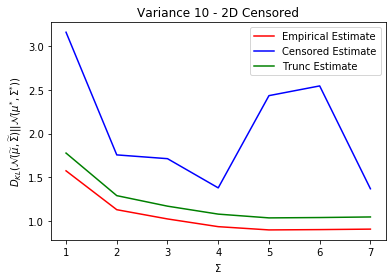

In [115]:
sns.lineplot(data=logs, x='var', y='kl_div_emp', color='red', label='Empirical Estimate')
sns.lineplot(data=logs, x='var', y='kl_div_censored', color='blue', label='Censored Estimate')
ax = sns.lineplot(data=logs, x='var', y='kl_div_trunc', color='green', label='Trunc Estimate')
ax.set_title('Censored Normal Varying Distribution Variance')
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('$D_{KL}(\mathcal{N}(\widetilde{\mu}, \widetilde{\Sigma}) || \mathcal{N}(\mu^{*}, \Sigma^{*}))$')
ax.set_title('Variance 10 - 2D Censored')
ax.legend()
plt.show()

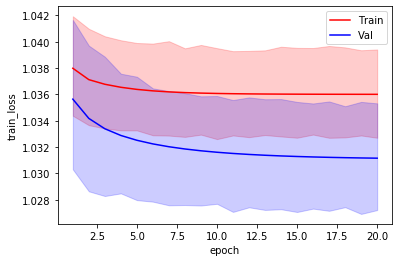

In [346]:
sns.lineplot(data=logs_, x='epoch', y='train_loss', color='red', label='Train')
sns.lineplot(data=logs_, x='epoch', y='val_loss', color='blue', label='Val')

In [351]:
censor_dist.loc, censor_dist.covariance_matrix

(tensor([ 0.2931, -0.1860]), tensor([[3.5046, 0.0932],
         [0.1074, 3.2324]]))

In [352]:
trunc_dist.loc, trunc_dist.covariance_matrix

(tensor([0.3827, 0.0240]), tensor([[ 0.6787, -0.0483],
         [-0.0475,  0.6449]]))

In [359]:
censored.covariance_matrix @ emp_cov

tensor([[3.5046, 0.0932],
        [0.1074, 3.2324]])

tensor([[1.2817, 0.0298],
        [0.0298, 1.2920]])

In [12]:
import math

In [15]:
math.log(1.0)

0.0